In [2]:
# Import required libraries

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML, display

# Imports for the high pass signal
from scipy.signal import butter, freqz, lfilter

# KFold
from sklearn.model_selection import KFold

# Import required modules
from sklearn.preprocessing import StandardScaler

import os.path

# To write WAV File
from scipy.io.wavfile import write

# To make derivative work on multiple CPUs
from concurrent.futures import ProcessPoolExecutor
from functools import partial

import sys

importing Jupyter notebook from analyze_data_cleaned.ipynb
measurement_id :  db2e053a-0fb8-4206-891a-6f079fb14e3a


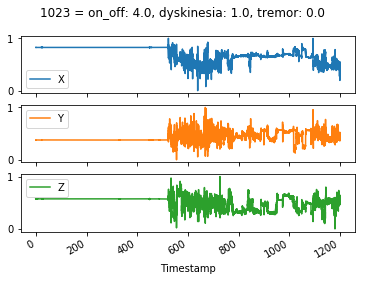

Working on  db2e053a-0fb8-4206-891a-6f079fb14e3a
LEN FILTERED DF :  59847


,Timestamp,X,Y,Z
0,0.000,0.968506,0.188232,0.181152
1,0.020,0.966553,0.187744,0.178223
2,0.040,0.968018,0.186768,0.177734
3,0.060,0.968018,0.188721,0.176270
4,0.080,0.967529,0.189209,0.178711
5,0.100,0.968994,0.188721,0.179199
6,0.120,0.966064,0.187256,0.179688
7,0.140,0.967529,0.190186,0.178711
8,0.160,0.968018,0.187256,0.179199
9,0.180,0.968506,0.188232,0.179199


KeyboardInterrupt: 

In [4]:
# Importing basic functions from other notebooks 
import import_ipynb
from analyze_data_cleaned import compute_symptoms_occurences_dataframe
from analyze_data_cleaned import plot_symptoms_occurences

# to be removed once i know how to import these from another notebook

In [5]:
def prepro_missing_values(df_train_label):
    """
    Filling NaN values with -1. 
    
    Keyword arguments:
    - df_train_label: DataFrame containing the following columns 
            [measurement_id, subject_id, on_off, tremor, dyskenisia]
    """
    # Replace NaN values with -1.0 because otherwise plotting triggers an error
    df_train_label = df_train_label.fillna(value=-1.0)
    return df_train_label


def compute_symptoms_occurences_dataframe(df_train_label):
    """
    Computes how many times the symptoms are occuring for a single subject_id 
    
    Keyword arguments:
    - df_train_label: DataFrame containing the following columns 
            [measurement_id, subject_id, on_off, tremor, dyskenisia]
    """
    df_train_label = prepro_missing_values(df_train_label=df_train_label)

    # Group data by subject_id
    df_train_label_subject_id = df_train_label.groupby("subject_id")

    df_occurences = []
    symptoms = ["on_off", "dyskinesia", "tremor"]

    for key, value in df_train_label_subject_id:
        for symptom in symptoms:
            # Pour un patient, prendre les 3 dernieres colonnes, et pour 1 symptome, calculer le nb d'occurences
            counter = (
                df_train_label_subject_id.get_group(key)
                .iloc[:, -3:][symptom]
                .value_counts()
            )

            for symptom_value, symptom_occurence in counter.items():
                df_occurences.append(
                    (
                        {
                            "subject_id": key,
                            "symptom": symptom,
                            "symptom_value": symptom_value,
                            "occurence": symptom_occurence,
                        }
                    )
                )

    df_occurences = pd.DataFrame(
        df_occurences, columns=("subject_id", "symptom", "symptom_value", "occurence")
    )

    return df_occurences, df_train_label_subject_id

In [35]:
# Source: https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

In [32]:
def plot_symptoms_occurences(df_occurences, df_train_label_subject_id):
    """
    This function plots the occurences of symptoms according to subject_id 

    Keyword Arguments: 
    - df_occurences: contains the df with occurences computed in compute_symptoms_occurences_dataframe
    - df_train_label_subject_id: contains df_train_label grouped by subject_id 
    """

    # There will be one graph plotted for each patient, for each of the 3 symptoms
    nb_subjects_id = (
        df_occurences.subject_id.nunique()
    )  # nb of unique patients in the label file
    print("Nb subject_id : ", nb_subjects_id)
#     height = 30 if nb_subjects_id > 10 else 5
#     fig, axes = plt.subplots(
#         nrows=nb_subjects_id, ncols=3, figsize=(10, height), sharey=True
#     )  # 3 cols for the 3 symptoms

    # Quick fix to plot the graphs at the right place. Starts at -1 because in the first for loop
    # it is incremented
#     patient = -1
    symptoms = ["on_off", "dyskinesia", "tremor"]
    for key, value in df_train_label_subject_id:
        for symptom in symptoms:
            df = df_train_label_subject_id.get_group(key)[symptom].value_counts()
            display(df)
            print(type(df))
            fig = plt.figure()
            ax = fig.add_subplot(221)
            plt.plot(x,y)

            ax = fig.add_subplot(222)
            plt.plot(x,z)

            ax = fig.add_subplot(223)
            plt.plot(x,z)

            plt.show()

#     # Plot for all subject_id 3 bar plots for all the symptoms and their occurences
#     # Reminder that NaN values (missing values) were replaced with -1 and are shown as such in the plots
#     symptoms = ["on_off", "dyskinesia", "tremor"]
#     for key, value in df_train_label_subject_id:
#         patient = patient + 1  # value used to position the plots (row)
#         symptom_no = 0  # value only used to position the plots (col)
#         for symptom in symptoms:

#             subject_symptom = " ".join(
#                 [str(key), symptom]
#             )  # variable used to create a title for each plot

#             df_train_label_subject_id.get_group(key)[symptom].value_counts().plot(
#                 kind="bar",
#                 x=symptom,
#                 title=subject_symptom,
#                 ax=axes[symptom_no],
#                 sharey=True,
#             )
#             xlocs, xlabs = plt.xticks()
#             for i, v in enumerate(df_train_label_subject_id.get_group(key)[symptom].value_counts()):
#                 plt.text(xlocs[i] - 0.25, v + 0.01, str(v))
#             fig.tight_layout()
#             plt.tight_layout()
#             symptom_no = symptom_no + 1
            
#         plt.show()
            

In [44]:
def plot_symptoms_occurences(df_occurences, df_train_label_subject_id):
    """
    This function plots the occurences of symptoms according to subject_id 

    Keyword Arguments: 
    - df_occurences: contains the df with occurences computed in compute_symptoms_occurences_dataframe
    - df_train_label_subject_id: contains df_train_label grouped by subject_id 
    """

    # There will be one graph plotted for each patient, for each of the 3 symptoms
    nb_subjects_id = (
        df_occurences.subject_id.nunique()
    )  # nb of unique patients in the label file
    print("Nb subject_id : ", nb_subjects_id)
    height = 30 if nb_subjects_id > 10 else 5
    fig, axes = plt.subplots(
        nrows=nb_subjects_id, ncols=3, figsize=(10, height), sharey=True
    )  # 3 cols for the 3 symptoms

    # Quick fix to plot the graphs at the right place. Starts at -1 because in the first for loop
    # it is incremented
    patient = -1
    
    # Plot for all subject_id 3 bar plots for all the symptoms and their occurences
    # Reminder that NaN values (missing values) were replaced with -1 and are shown as such in the plots
    symptoms = ["on_off", "dyskinesia", "tremor"]
    for key, value in df_train_label_subject_id:
        patient = patient + 1  # value used to position the plots (row)
        symptom_no = 0  # value only used to position the plots (col)
        for symptom in symptoms:

            subject_symptom = " ".join(
                [str(key), symptom]
            )  # variable used to create a title for each plot

#             ax = freq_series.plot(kind='bar')
            ax = df_train_label_subject_id.get_group(key)[symptom].value_counts().plot(
                kind="bar",
                x=symptom,
                title=subject_symptom,
                ax=axes[symptom_no],
                sharey=True,
            )
#             xlocs, xlabs = plt.xticks()
#             for i, v in enumerate(df_train_label_subject_id.get_group(key)[symptom].value_counts()):
#                 plt.text(xlocs[i] - 0.25, v + 0.01, str(v))
            fig.tight_layout()
            plt.tight_layout()
            symptom_no = symptom_no + 1
            add_value_labels(ax)
        plt.show()
            

In [42]:
# def plot_symptoms_occurences(df_occurences, df_train_label_subject_id):
#     """
#     This function plots the occurences of symptoms according to subject_id 

#     Keyword Arguments: 
#     - df_occurences: contains the df with occurences computed in compute_symptoms_occurences_dataframe
#     - df_train_label_subject_id: contains df_train_label grouped by subject_id 
#     """

#     # There will be one graph plotted for each patient, for each of the 3 symptoms
#     nb_subjects_id = (
#         df_occurences.subject_id.nunique()
#     )  # nb of unique patients in the label file
#     print("Nb subject_id : ", nb_subjects_id)
#     height = 30 if nb_subjects_id > 10 else 5
#     fig, axes = plt.subplots(
#         nrows=nb_subjects_id, ncols=3, figsize=(10, height), sharey=True
#     )  # 3 cols for the 3 symptoms

#     # Quick fix to plot the graphs at the right place. Starts at -1 because in the first for loop
#     # it is incremented
#     patient = -1
    
#     # Plot for all subject_id 3 bar plots for all the symptoms and their occurences
#     # Reminder that NaN values (missing values) were replaced with -1 and are shown as such in the plots
#     symptoms = ["on_off", "dyskinesia", "tremor"]
#     for key, value in df_train_label_subject_id:
#         patient = patient + 1  # value used to position the plots (row)
#         symptom_no = 0  # value only used to position the plots (col)
#         for symptom in symptoms:

#             subject_symptom = " ".join(
#                 [str(key), symptom]
#             )  # variable used to create a title for each plot

            
#             df_train_label_subject_id.get_group(key)[symptom].value_counts().plot(
#                 kind="bar",
#                 x=symptom,
#                 title=subject_symptom,
#                 ax=axes[symptom_no],
#                 sharey=True,
#             )
# #             xlocs, xlabs = plt.xticks()
# #             for i, v in enumerate(df_train_label_subject_id.get_group(key)[symptom].value_counts()):
# #                 plt.text(xlocs[i] - 0.25, v + 0.01, str(v))
#             fig.tight_layout()
#             plt.tight_layout()
#             symptom_no = symptom_no + 1
# #             add_value_labels(axes)
#         plt.show()
            

### Analyze the kfold distribution V1

In [ ]:
data_type = "cis"
data_real_subtype=""

if data_type == "cis":
    kfold_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.k_fold_v1/"

data_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/"
data_path = data_path + data_type + "-pd.training_data/" + data_real_subtype + "/"

nb_folds = np.array([0,1,2,3,4])

pids = np.array([1004,1006,1007,1019,1020,1023,1032,1034,1038,1039,1043,1044,1046,1048,1049,1051])

for temp_pid in pids:
    for nb in nb_folds:
        for train_or_test in ['train','test']:
            file_name = str(temp_pid) + '_'+train_or_test+'_kfold_' + str(nb) + '.csv'
            print(file_name)
            df_train_label = pd.read_csv(kfold_path+file_name)
            # Compute the occurences of each symptoms for each patient

            df_occurences, df_train_label_subject_id = compute_symptoms_occurences_dataframe(
                df_train_label=df_train_label
            )

            # Plot the graphs
            plot_symptoms_occurences(
                df_occurences=df_occurences, df_train_label_subject_id=df_train_label_subject_id
            )

            #print(df_train_label.values[:,1:])
            #temp_train_X = pd.read_csv(data_path+df_train_label["measurement_id"][idx] + '.csv')

In [11]:
df_occurences, df_train_label_subject_id

(   subject_id     symptom  symptom_value  occurence
 0        1051      on_off            0.0        113
 1        1051      on_off            2.0         13
 2        1051      on_off            1.0         13
 3        1051      on_off            3.0         11
 4        1051      on_off            4.0          5
 5        1051      on_off           -1.0          1
 6        1051  dyskinesia           -1.0        156
 7        1051      tremor           -1.0        156,
 <pandas.core.groupby.groupby.DataFrameGroupBy object at 0x7fd901161b70>)

### Analyze the kfold distribution V2

1004_train_kfold_0.csv
Nb subject_id :  1


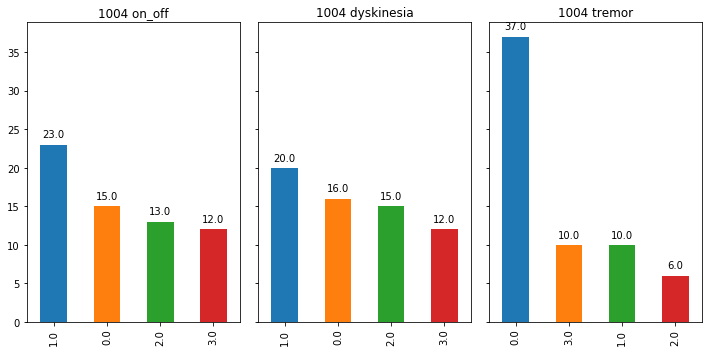

1004_test_kfold_0.csv
Nb subject_id :  1


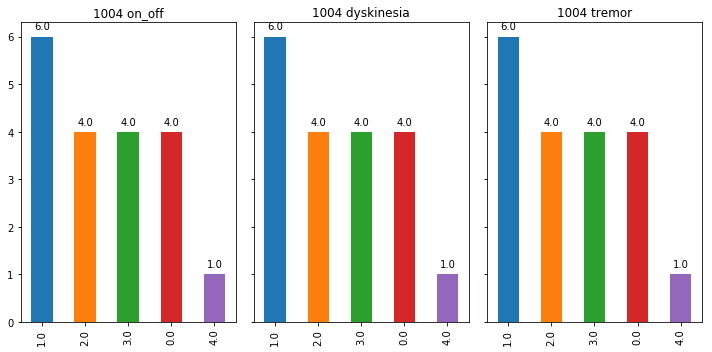

1004_train_kfold_1.csv
Nb subject_id :  1


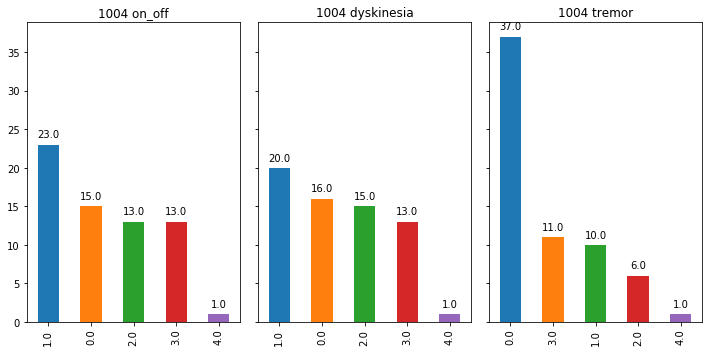

1004_test_kfold_1.csv
Nb subject_id :  1


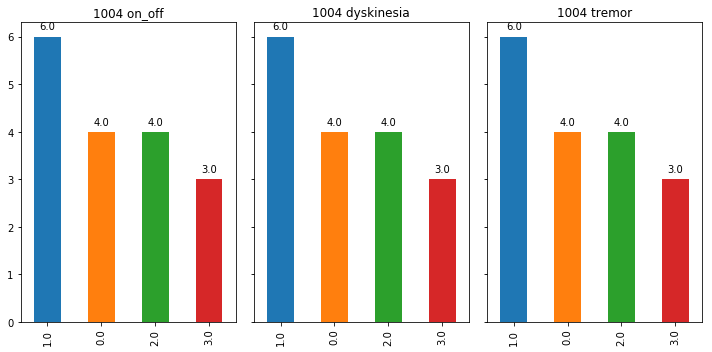

1004_train_kfold_2.csv
Nb subject_id :  1


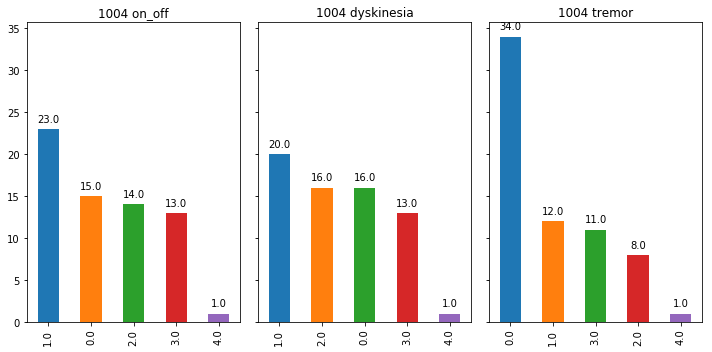

1004_test_kfold_2.csv
Nb subject_id :  1


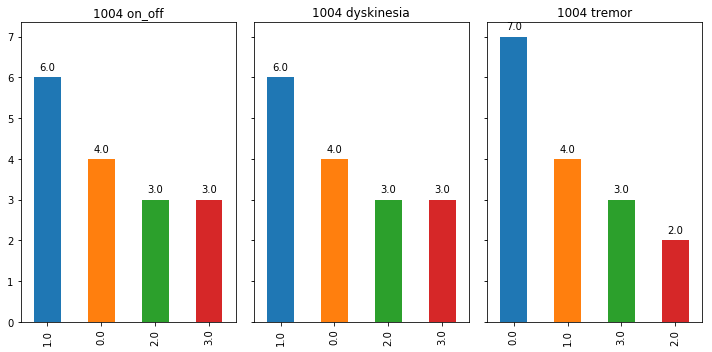

1004_train_kfold_3.csv
Nb subject_id :  1


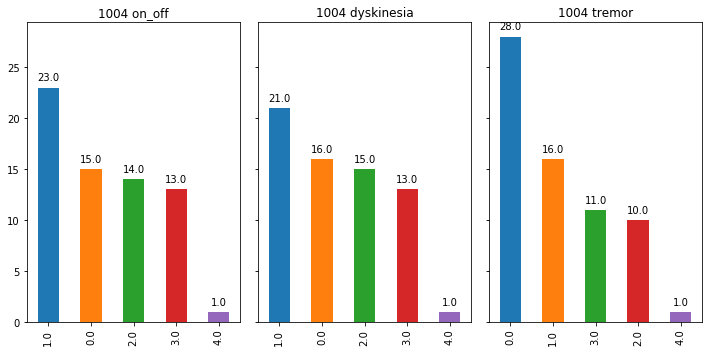

1004_test_kfold_3.csv
Nb subject_id :  1


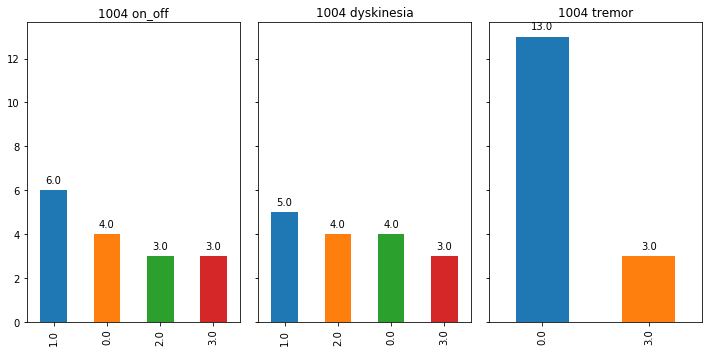

1004_train_kfold_4.csv
Nb subject_id :  1


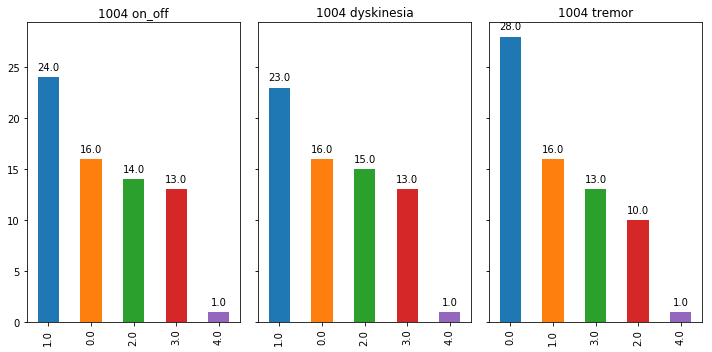

1004_test_kfold_4.csv
Nb subject_id :  1


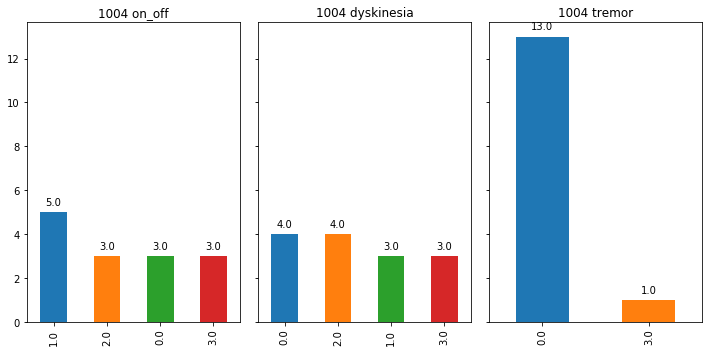

1006_train_kfold_0.csv
Nb subject_id :  1


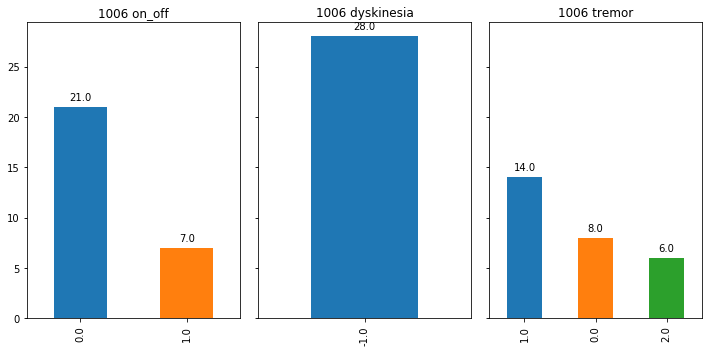

1006_test_kfold_0.csv
Nb subject_id :  1


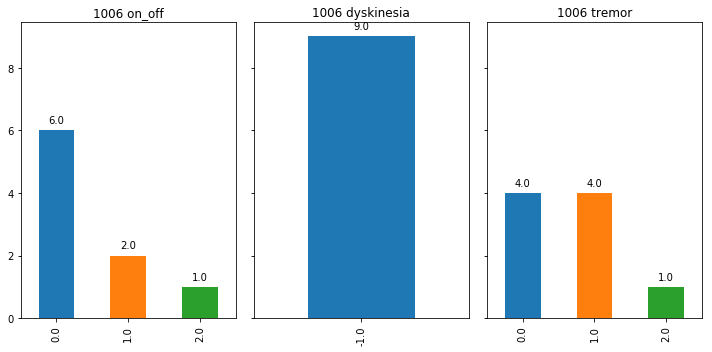

1006_train_kfold_1.csv
Nb subject_id :  1


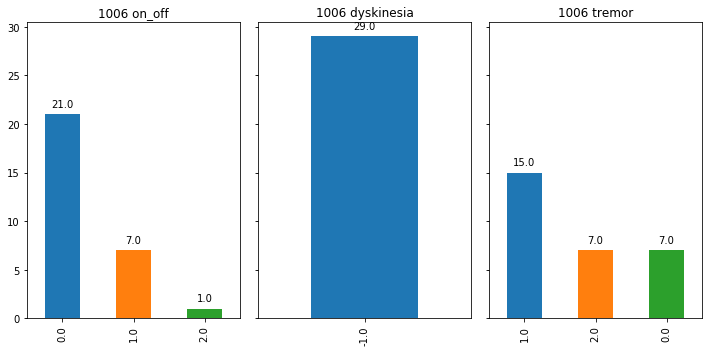

1006_test_kfold_1.csv
Nb subject_id :  1


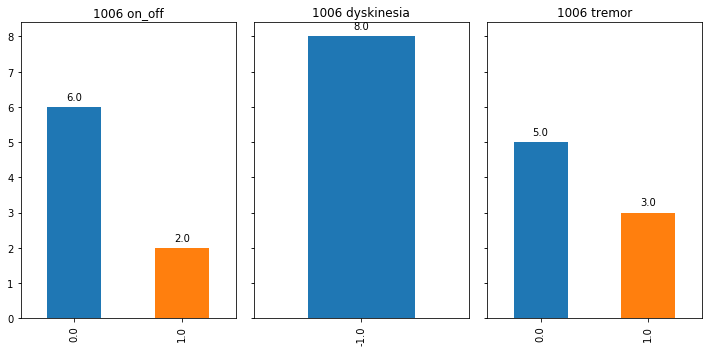

1006_train_kfold_2.csv
Nb subject_id :  1


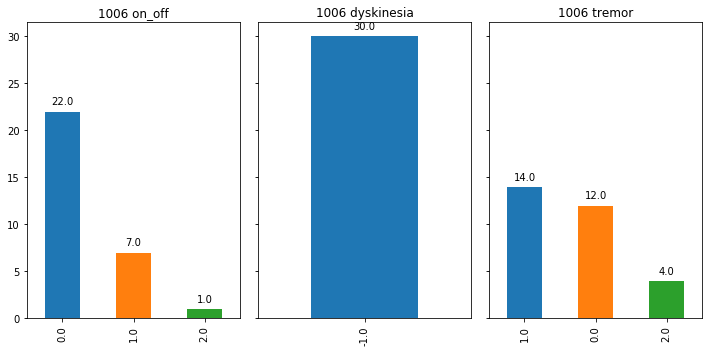

1006_test_kfold_2.csv
Nb subject_id :  1


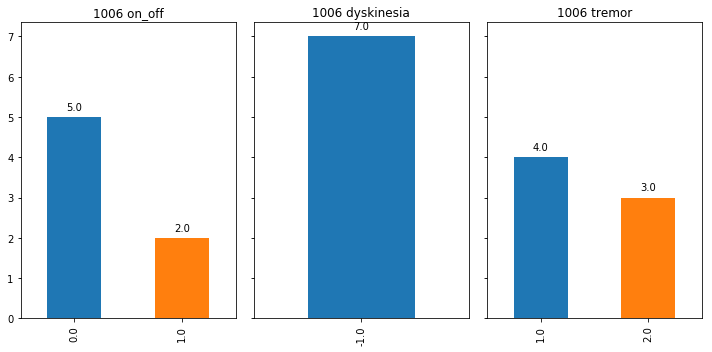

1006_train_kfold_3.csv
Nb subject_id :  1


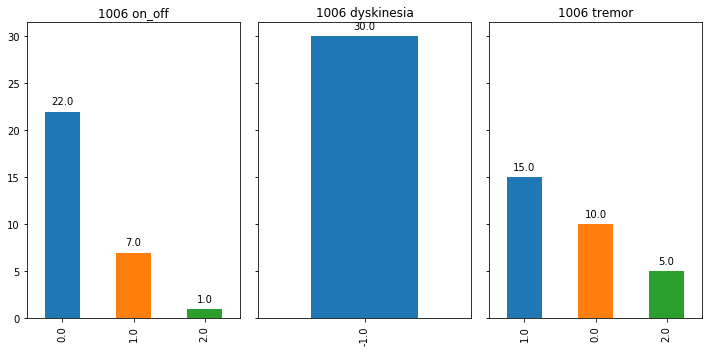

1006_test_kfold_3.csv
Nb subject_id :  1


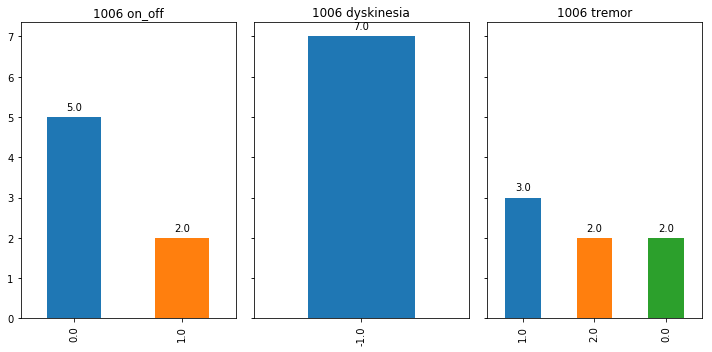

1006_train_kfold_4.csv
Nb subject_id :  1


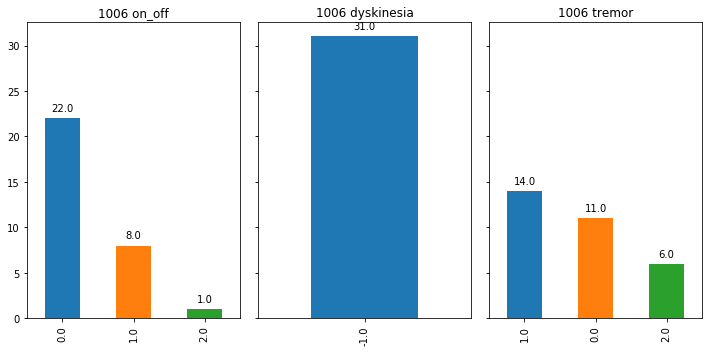

1006_test_kfold_4.csv
Nb subject_id :  1


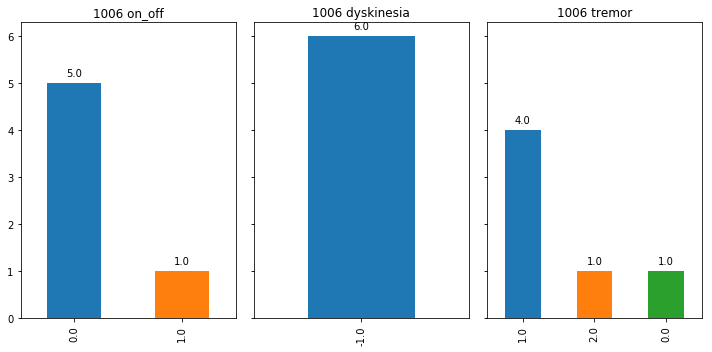

1007_train_kfold_0.csv
Nb subject_id :  1


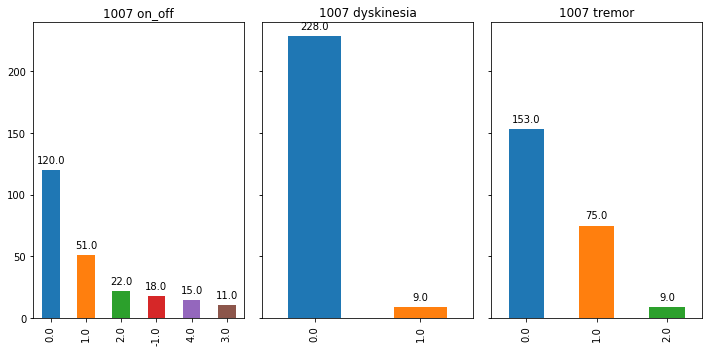

1007_test_kfold_0.csv
Nb subject_id :  1


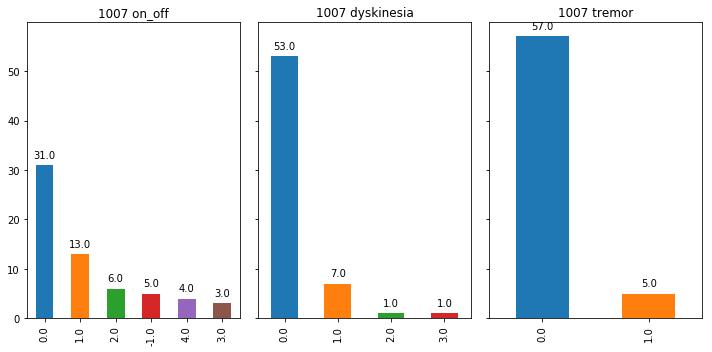

1007_train_kfold_1.csv
Nb subject_id :  1


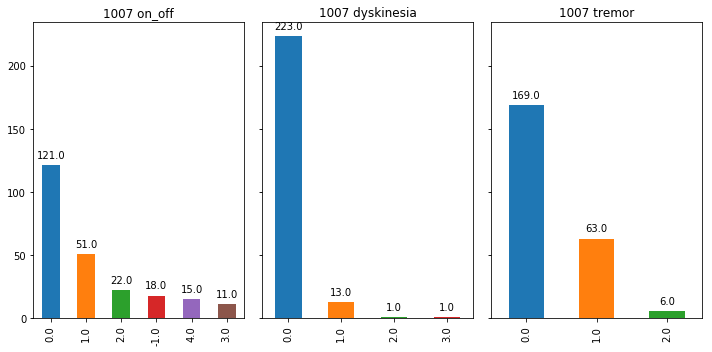

1007_test_kfold_1.csv
Nb subject_id :  1


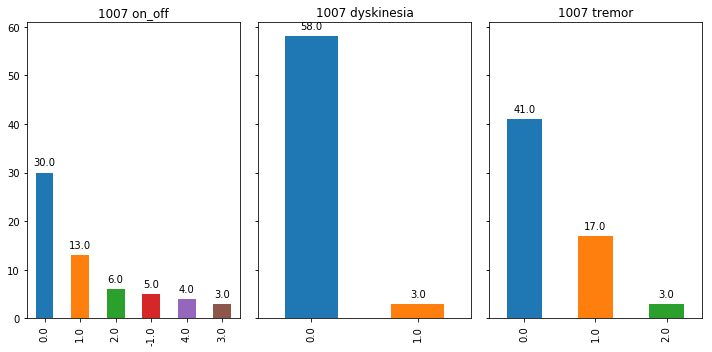

1007_train_kfold_2.csv
Nb subject_id :  1


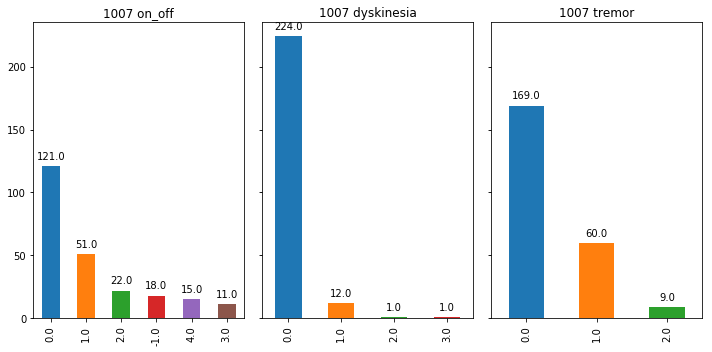

1007_test_kfold_2.csv
Nb subject_id :  1


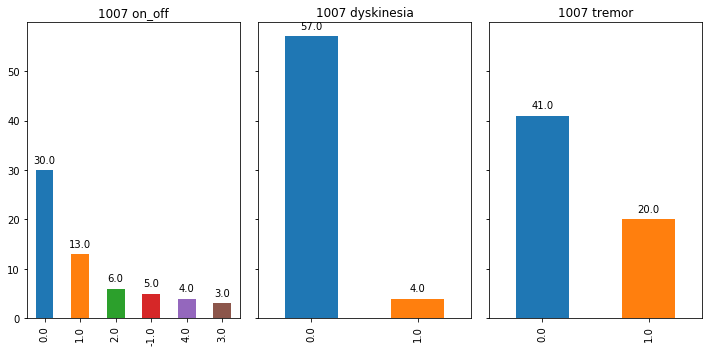

1007_train_kfold_3.csv
Nb subject_id :  1


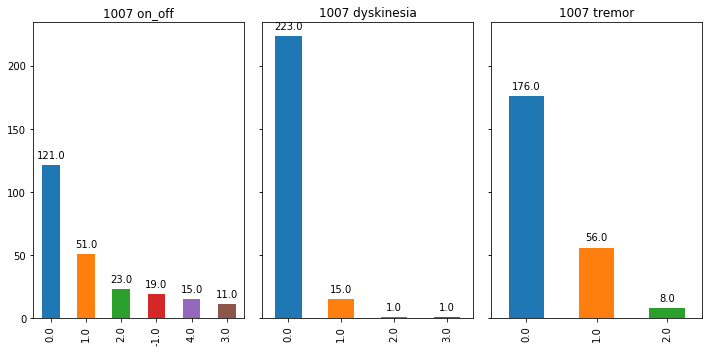

1007_test_kfold_3.csv
Nb subject_id :  1


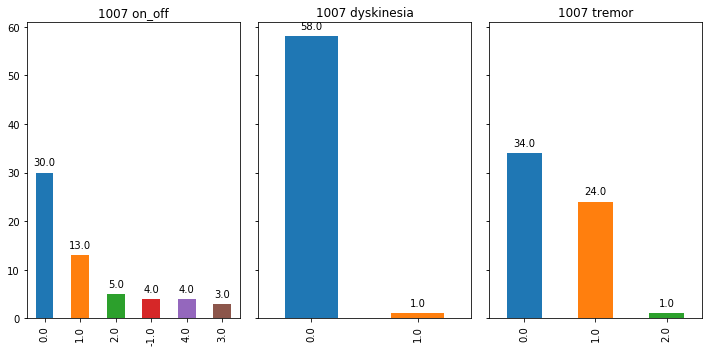

1007_train_kfold_4.csv
Nb subject_id :  1


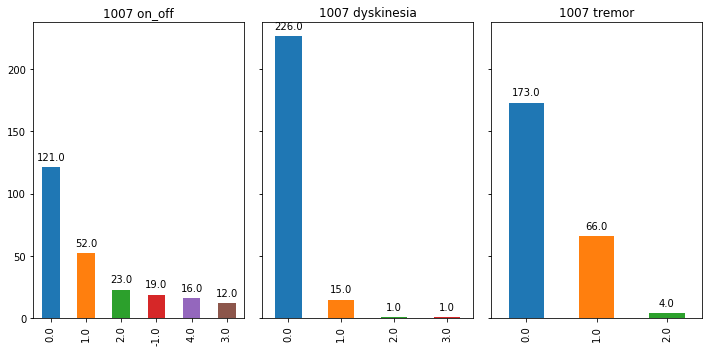

1007_test_kfold_4.csv
Nb subject_id :  1


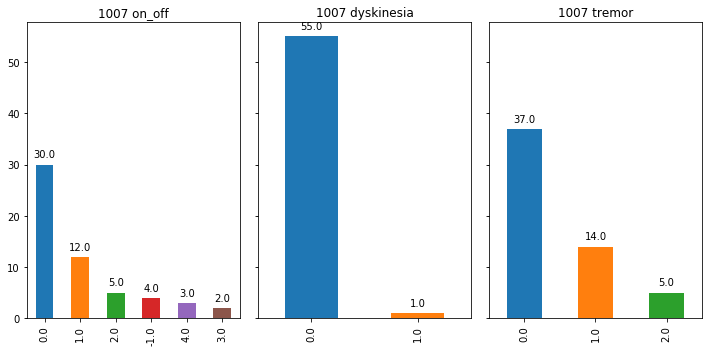

1019_train_kfold_0.csv
Nb subject_id :  1


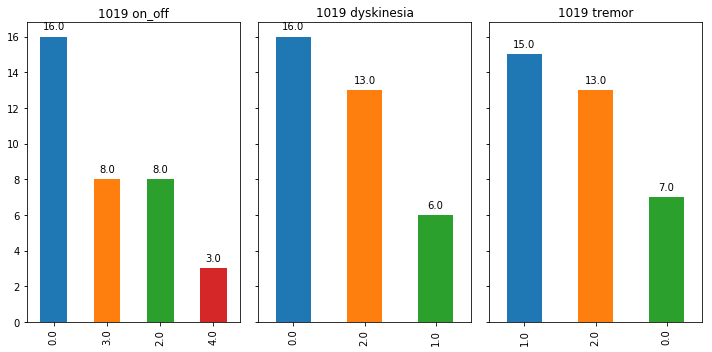

1019_test_kfold_0.csv
Nb subject_id :  1


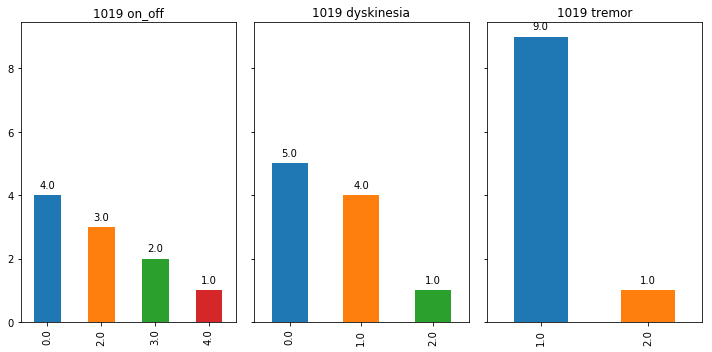

1019_train_kfold_1.csv
Nb subject_id :  1


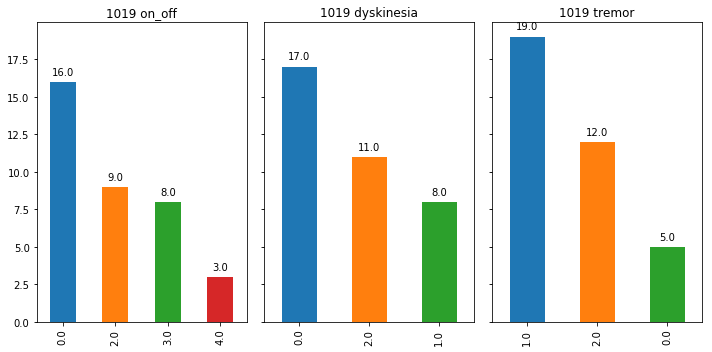

1019_test_kfold_1.csv
Nb subject_id :  1


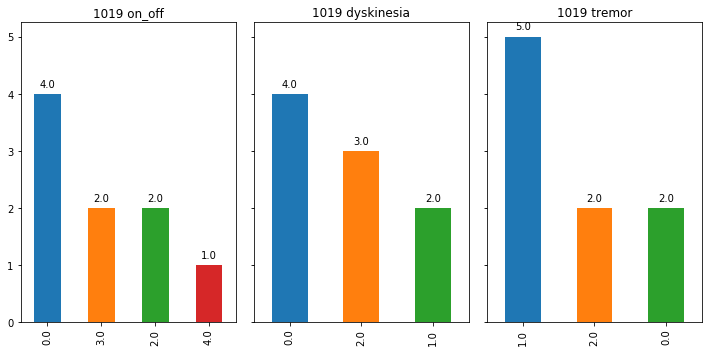

1019_train_kfold_2.csv
Nb subject_id :  1


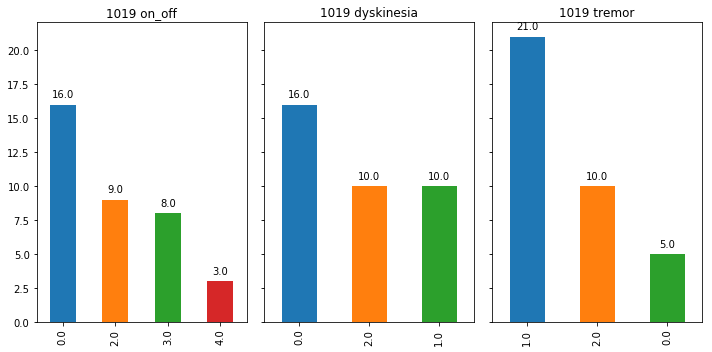

1019_test_kfold_2.csv
Nb subject_id :  1


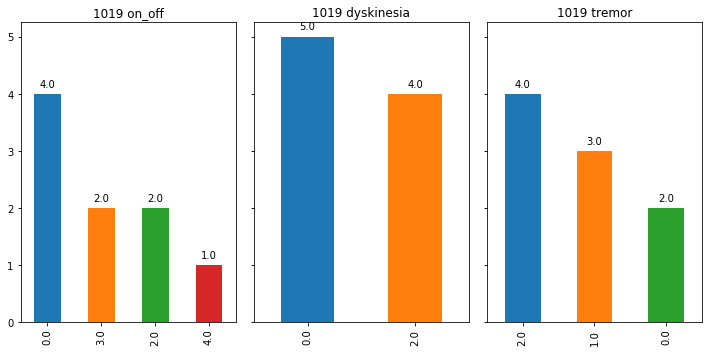

1019_train_kfold_3.csv
Nb subject_id :  1


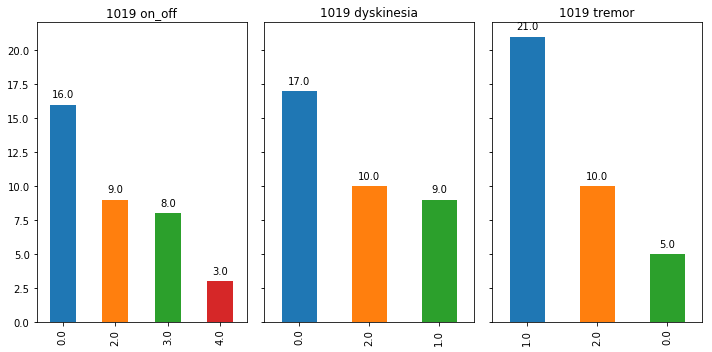

1019_test_kfold_3.csv
Nb subject_id :  1


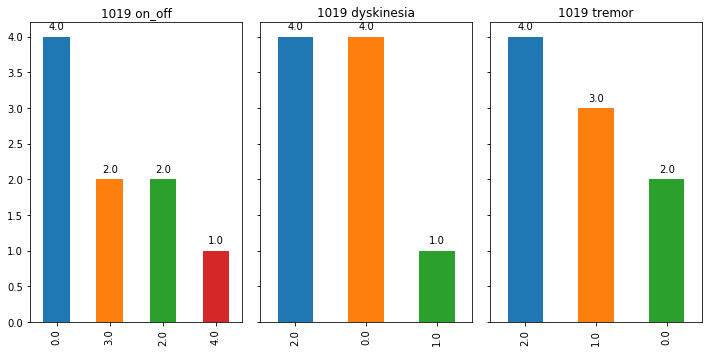

1019_train_kfold_4.csv
Nb subject_id :  1


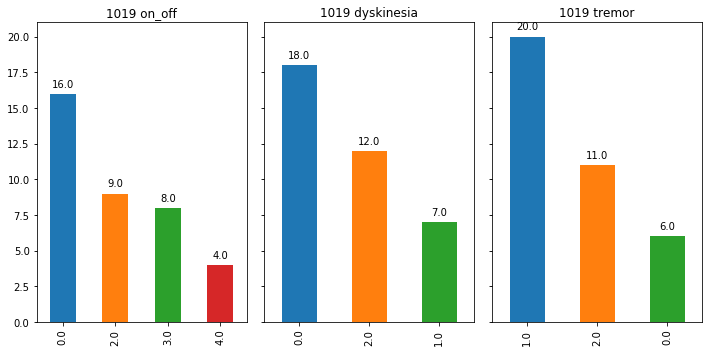

1019_test_kfold_4.csv
Nb subject_id :  1


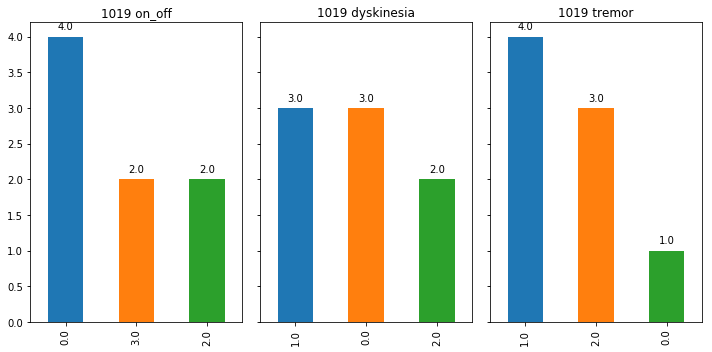

1020_train_kfold_0.csv
Nb subject_id :  1


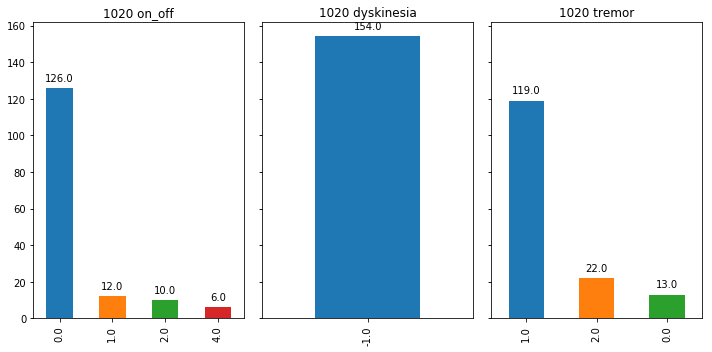

1020_test_kfold_0.csv
Nb subject_id :  1


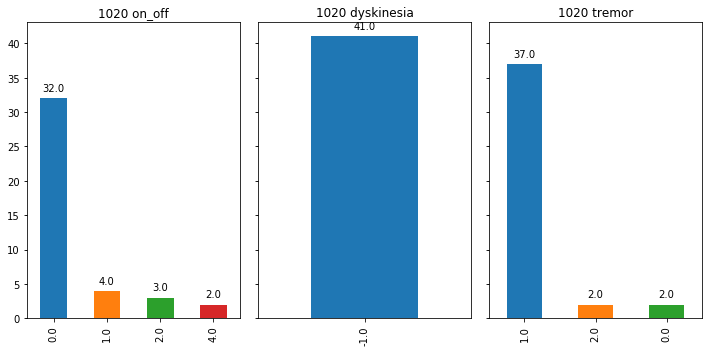

1020_train_kfold_1.csv
Nb subject_id :  1


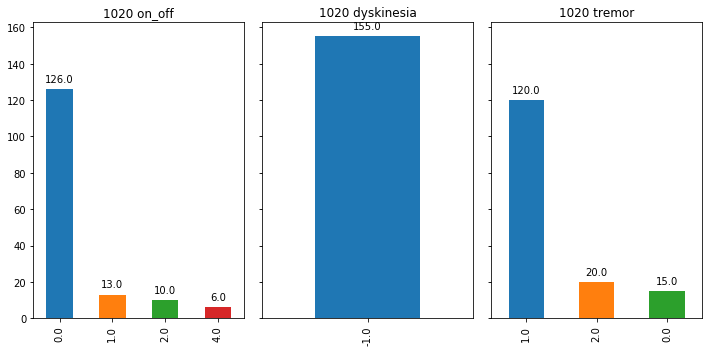

1020_test_kfold_1.csv
Nb subject_id :  1


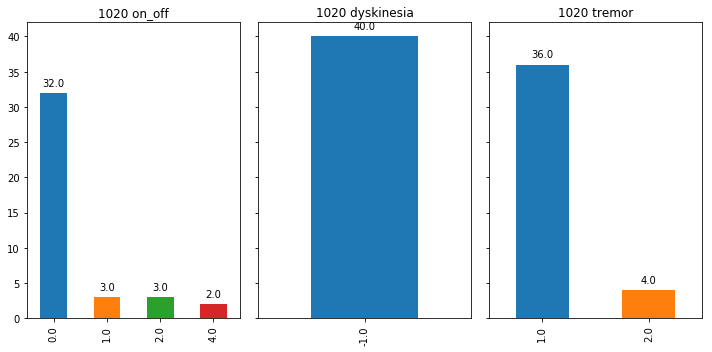

1020_train_kfold_2.csv
Nb subject_id :  1


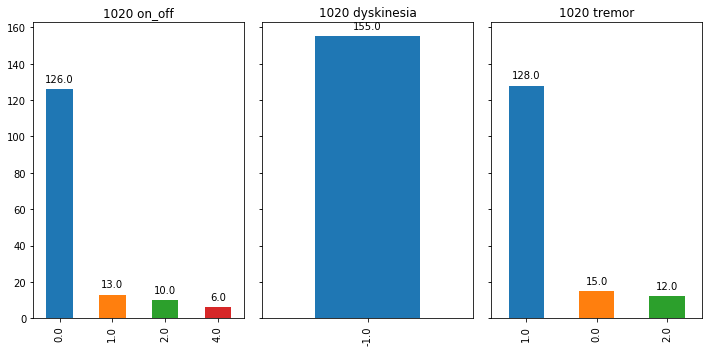

1020_test_kfold_2.csv
Nb subject_id :  1


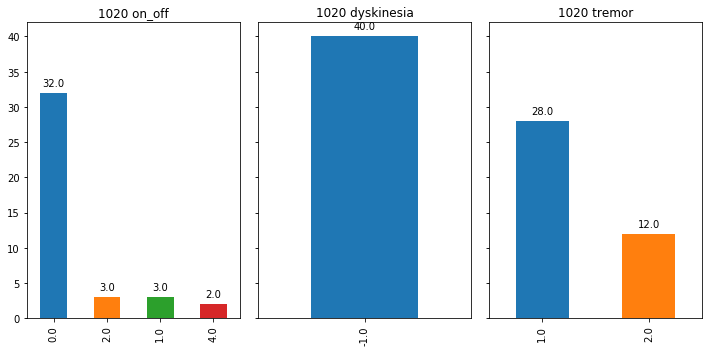

1020_train_kfold_3.csv
Nb subject_id :  1


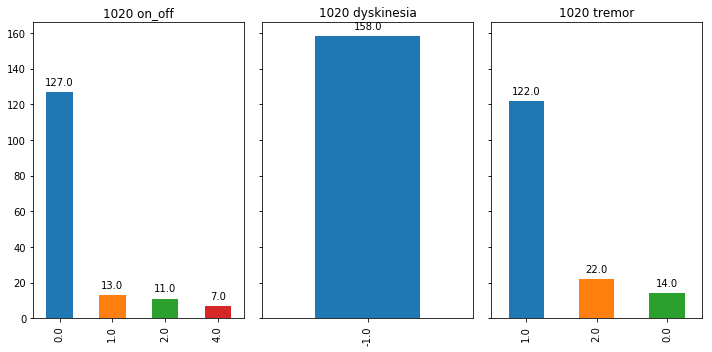

1020_test_kfold_3.csv
Nb subject_id :  1


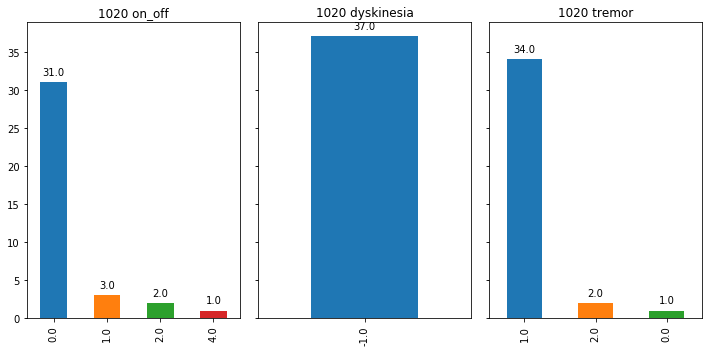

1020_train_kfold_4.csv
Nb subject_id :  1


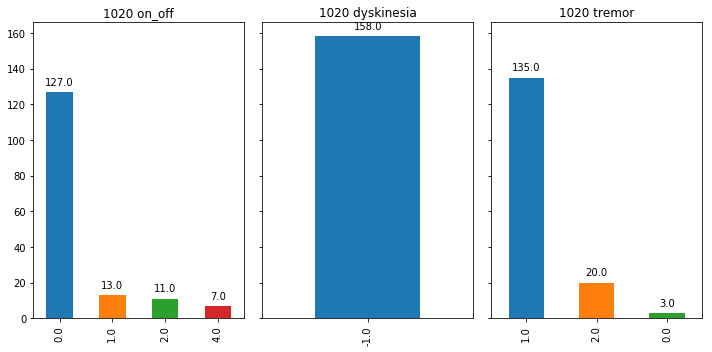

1020_test_kfold_4.csv
Nb subject_id :  1


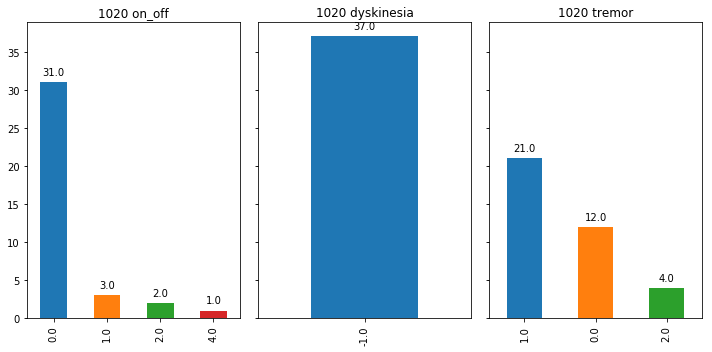

1023_train_kfold_0.csv
Nb subject_id :  1


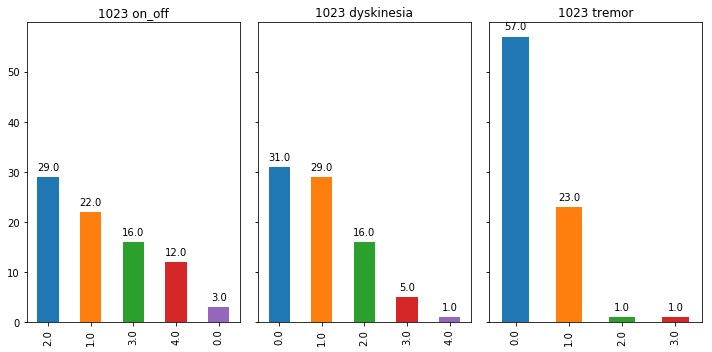

1023_test_kfold_0.csv
Nb subject_id :  1


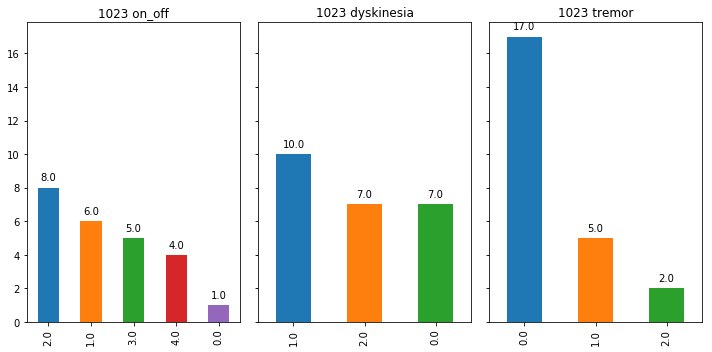

1023_train_kfold_1.csv
Nb subject_id :  1


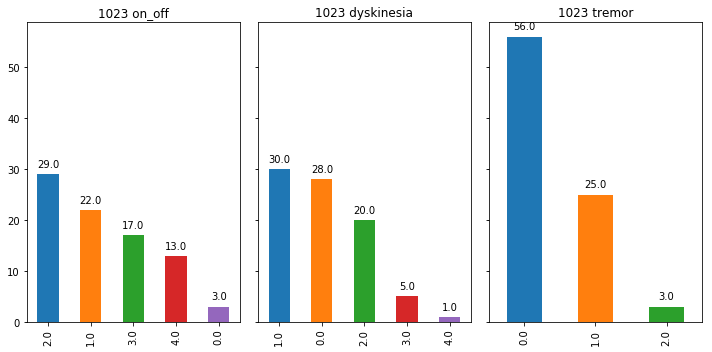

1023_test_kfold_1.csv
Nb subject_id :  1


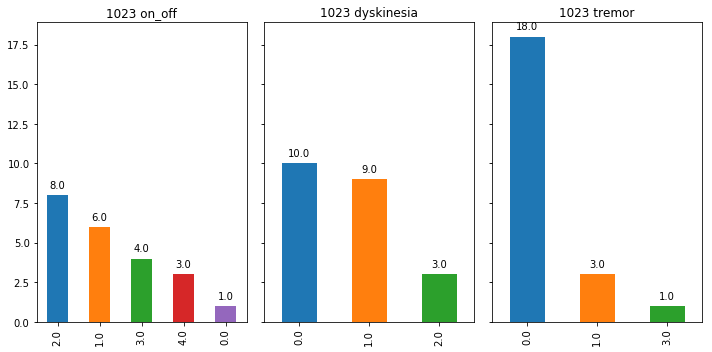

1023_train_kfold_2.csv
Nb subject_id :  1


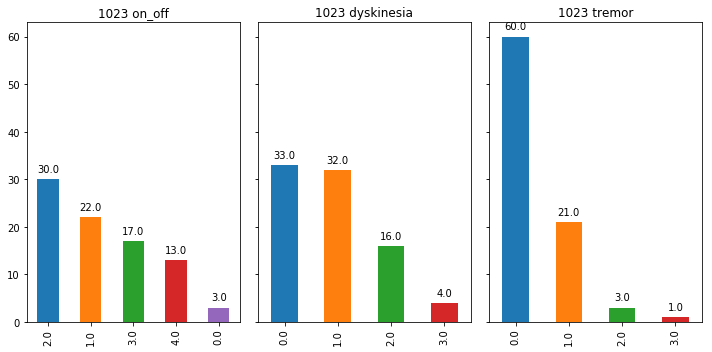

1023_test_kfold_2.csv
Nb subject_id :  1


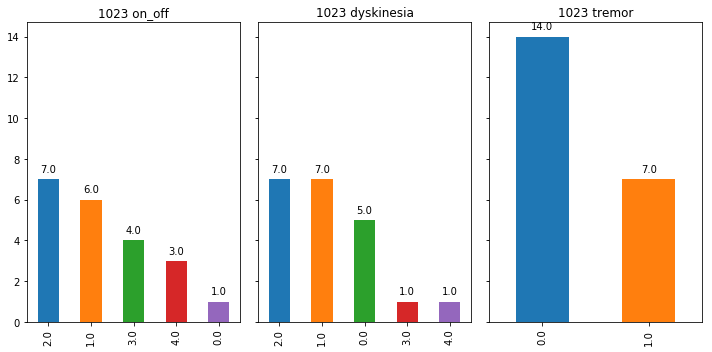

1023_train_kfold_3.csv
Nb subject_id :  1


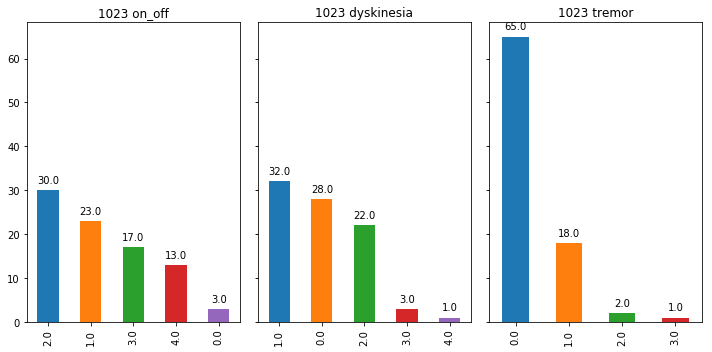

1023_test_kfold_3.csv
Nb subject_id :  1


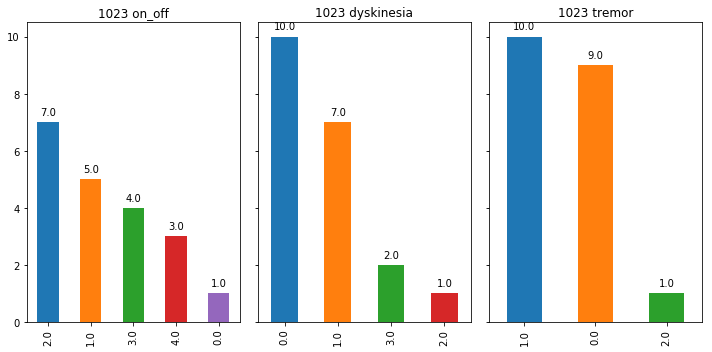

1023_train_kfold_4.csv
Nb subject_id :  1


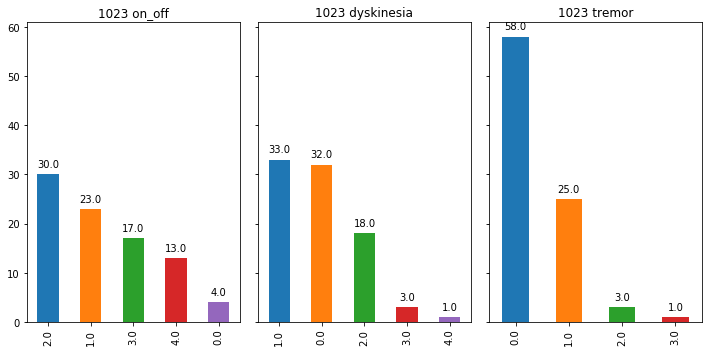

1023_test_kfold_4.csv
Nb subject_id :  1


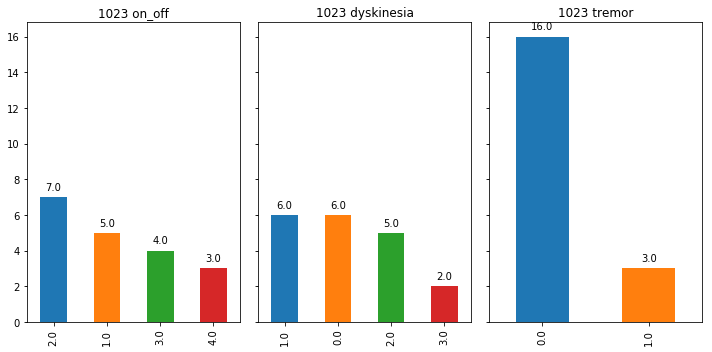

1032_train_kfold_0.csv
Nb subject_id :  1


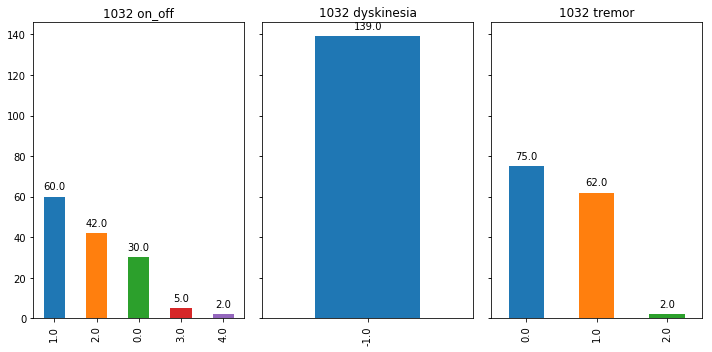

1032_test_kfold_0.csv
Nb subject_id :  1


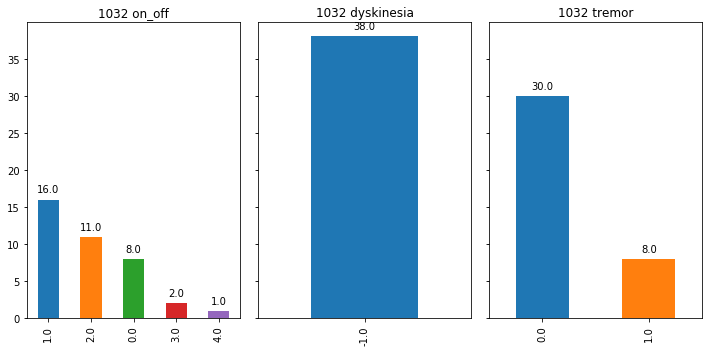

1032_train_kfold_1.csv
Nb subject_id :  1


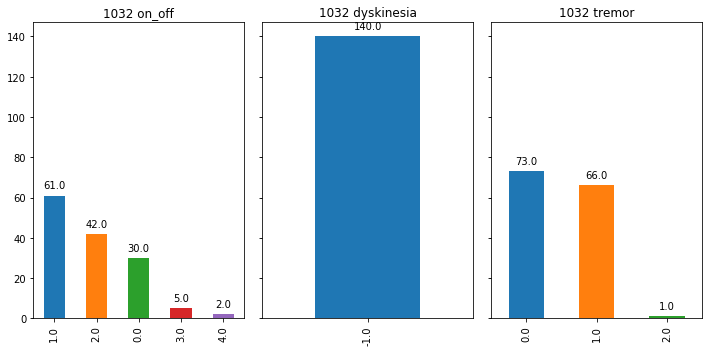

1032_test_kfold_1.csv
Nb subject_id :  1


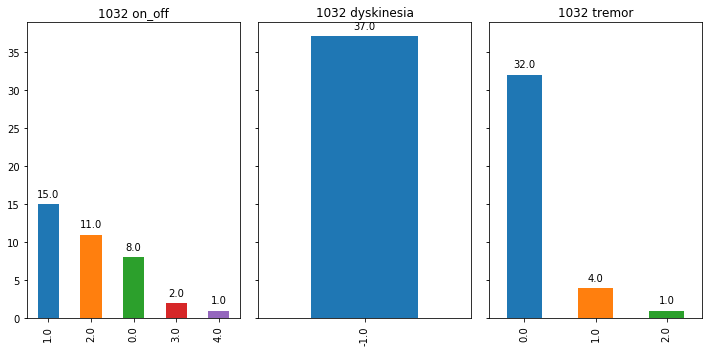

1032_train_kfold_2.csv
Nb subject_id :  1


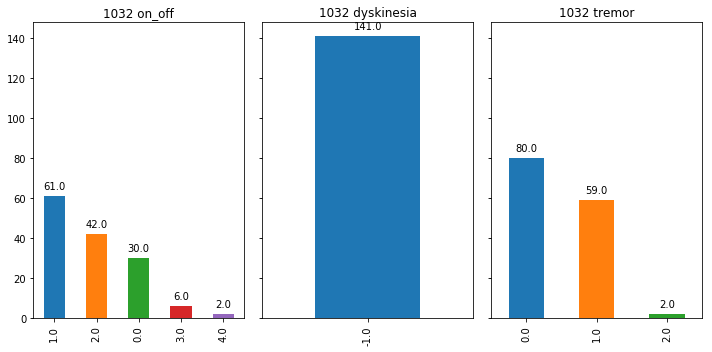

1032_test_kfold_2.csv
Nb subject_id :  1


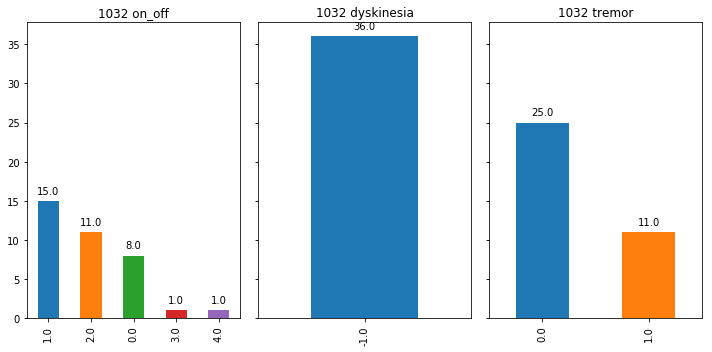

1032_train_kfold_3.csv
Nb subject_id :  1


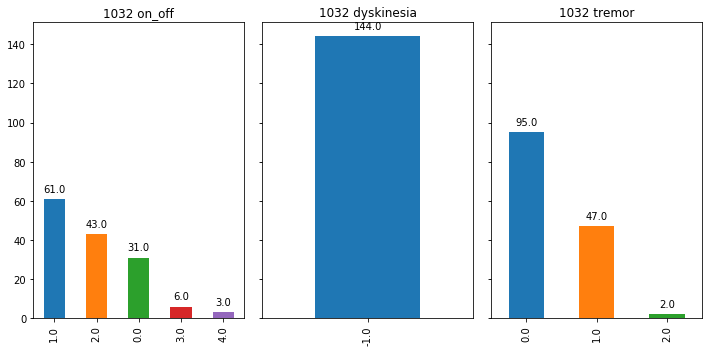

1032_test_kfold_3.csv
Nb subject_id :  1


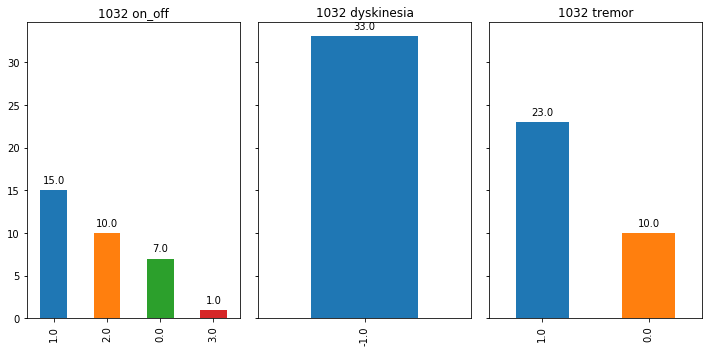

1032_train_kfold_4.csv
Nb subject_id :  1


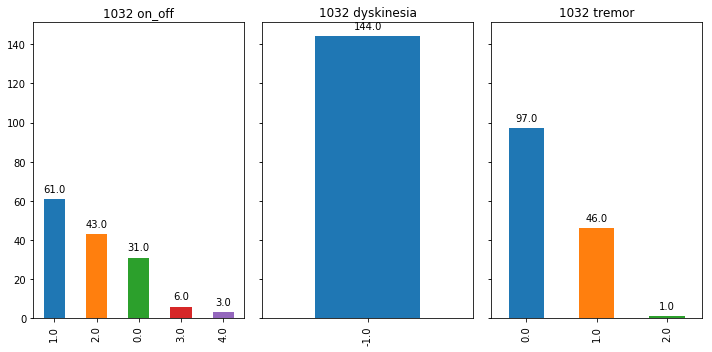

1032_test_kfold_4.csv
Nb subject_id :  1


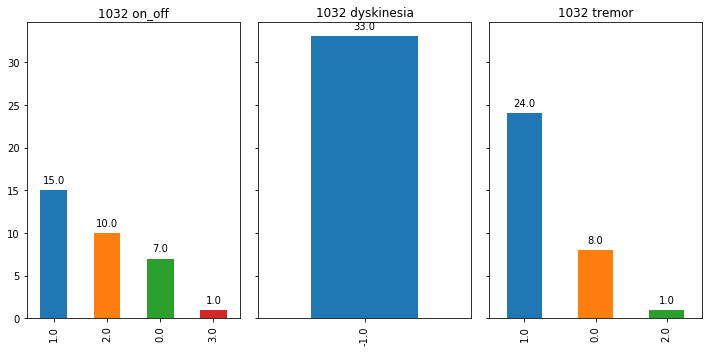

1034_train_kfold_0.csv
Nb subject_id :  1


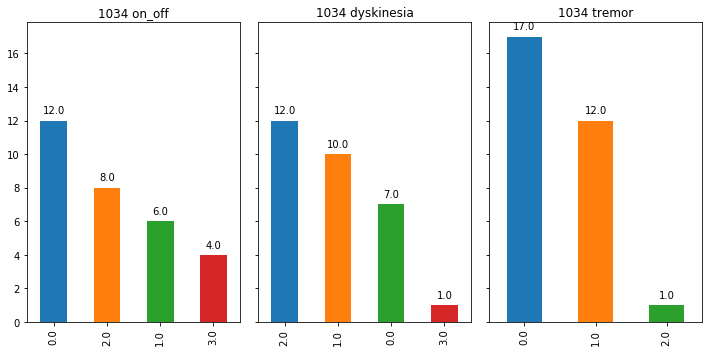

1034_test_kfold_0.csv
Nb subject_id :  1


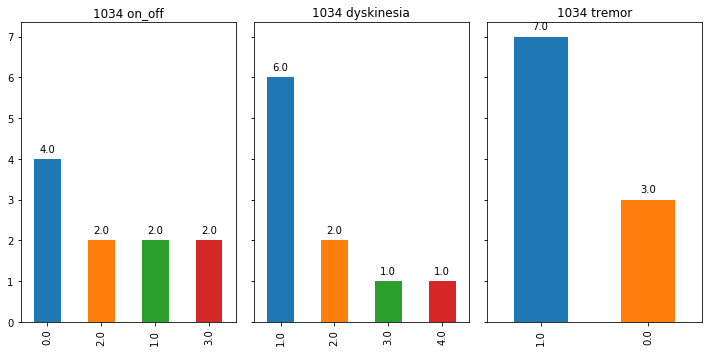

1034_train_kfold_1.csv
Nb subject_id :  1


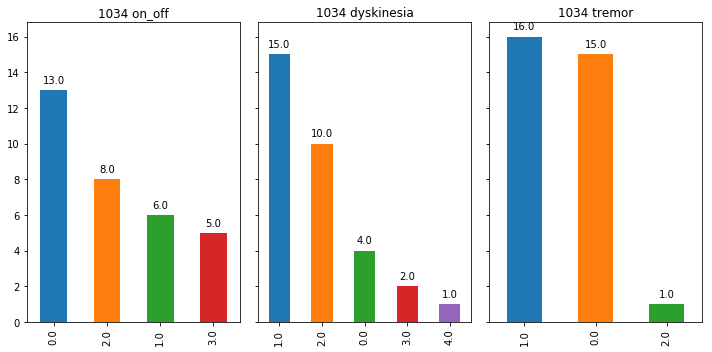

1034_test_kfold_1.csv
Nb subject_id :  1


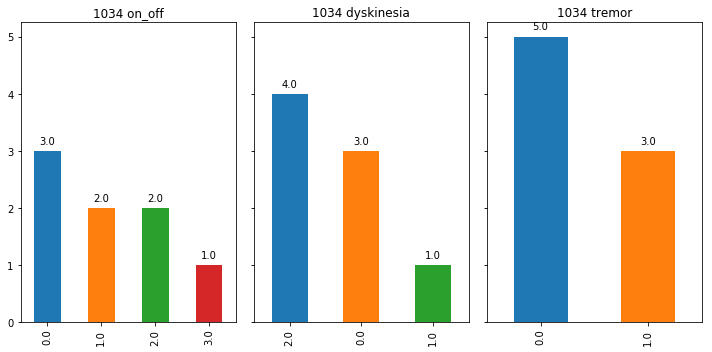

1034_train_kfold_2.csv
Nb subject_id :  1


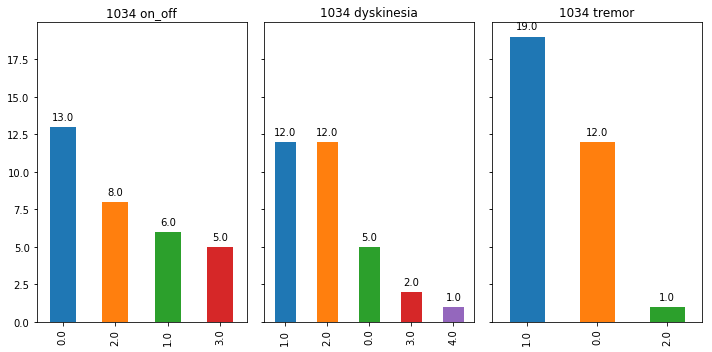

1034_test_kfold_2.csv
Nb subject_id :  1


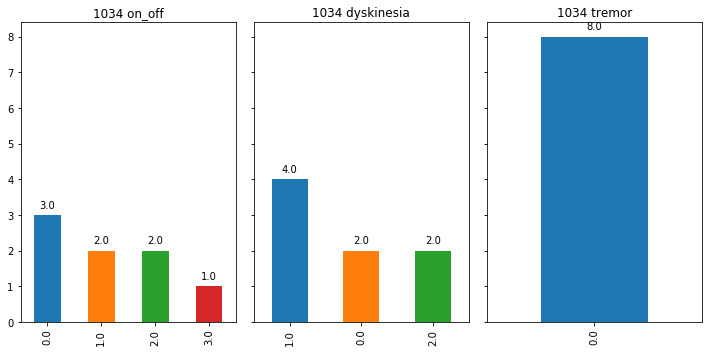

1034_train_kfold_3.csv
Nb subject_id :  1


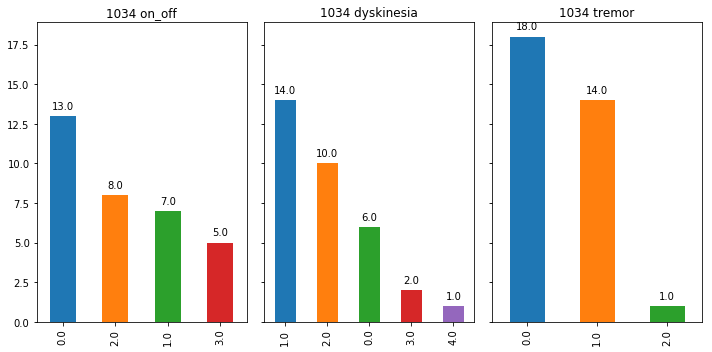

1034_test_kfold_3.csv
Nb subject_id :  1


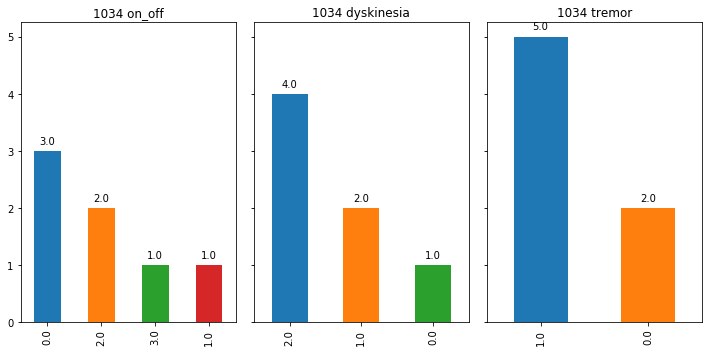

1034_train_kfold_4.csv
Nb subject_id :  1


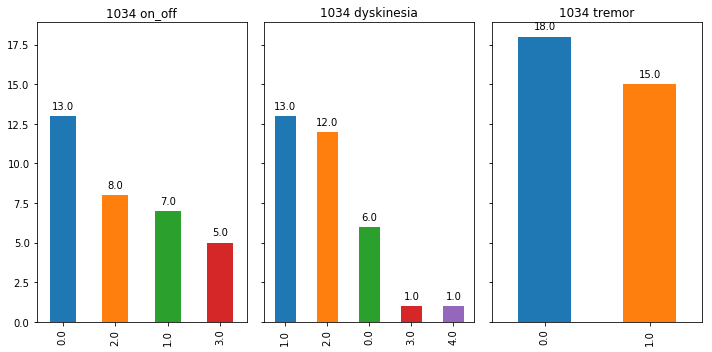

1034_test_kfold_4.csv
Nb subject_id :  1


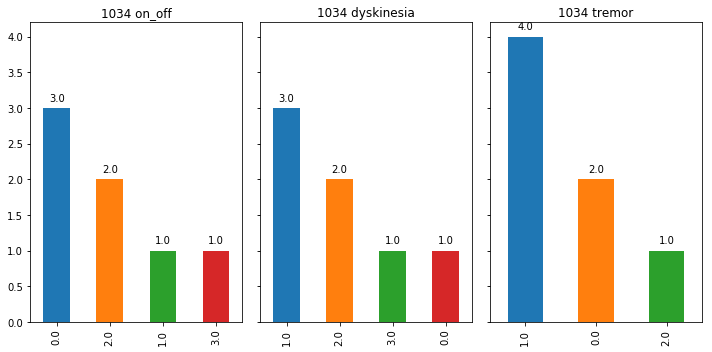

1038_train_kfold_0.csv
Nb subject_id :  1


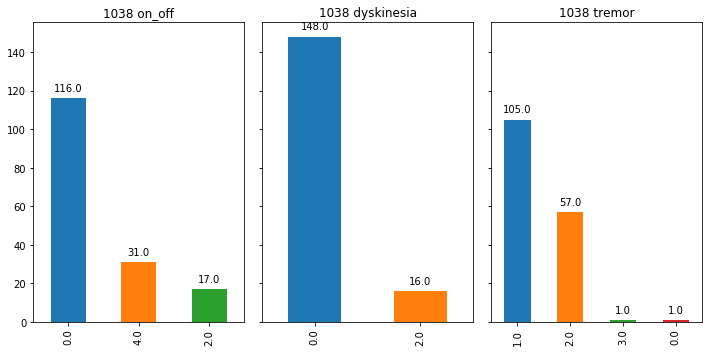

1038_test_kfold_0.csv
Nb subject_id :  1


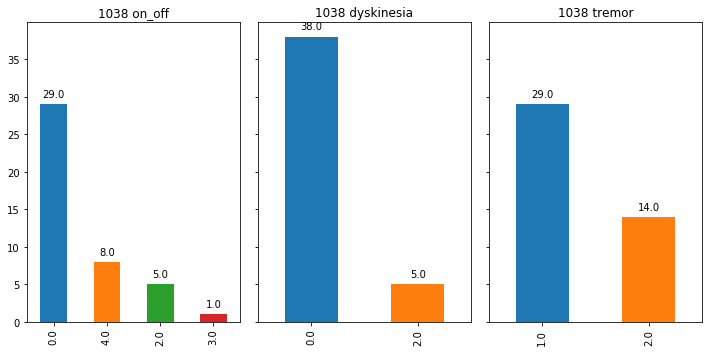

1038_train_kfold_1.csv
Nb subject_id :  1


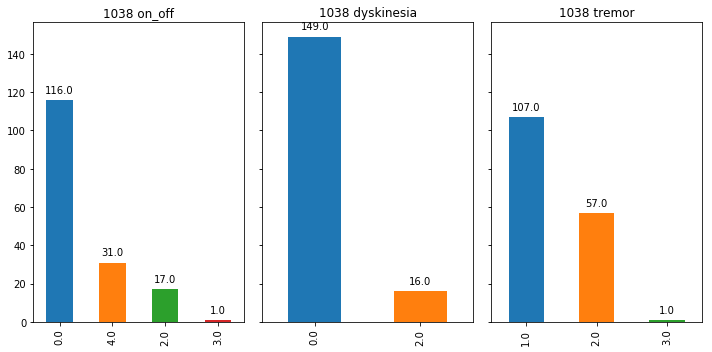

1038_test_kfold_1.csv
Nb subject_id :  1


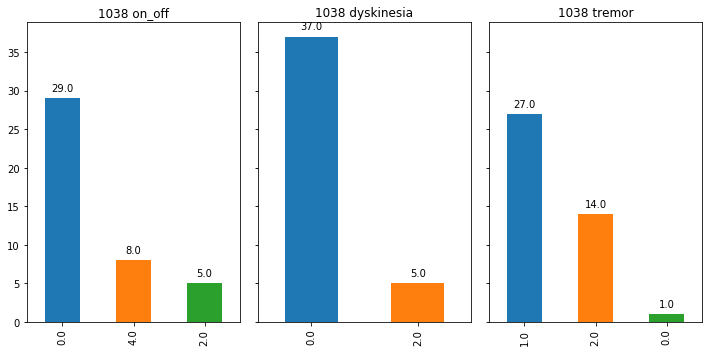

1038_train_kfold_2.csv
Nb subject_id :  1


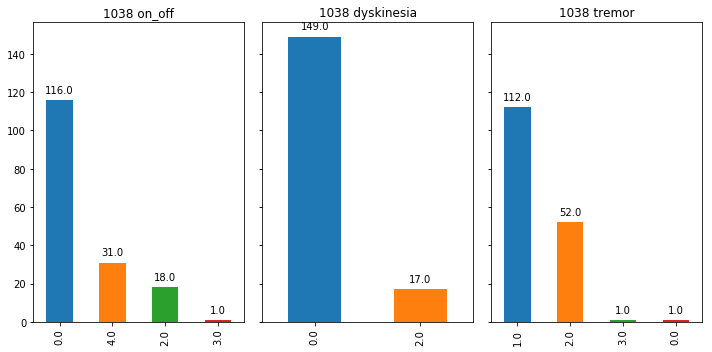

1038_test_kfold_2.csv
Nb subject_id :  1


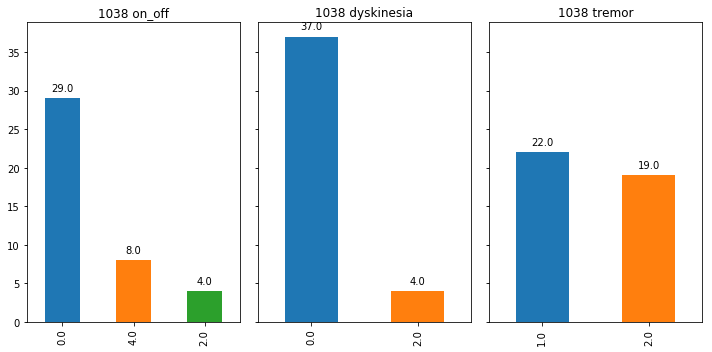

1038_train_kfold_3.csv
Nb subject_id :  1


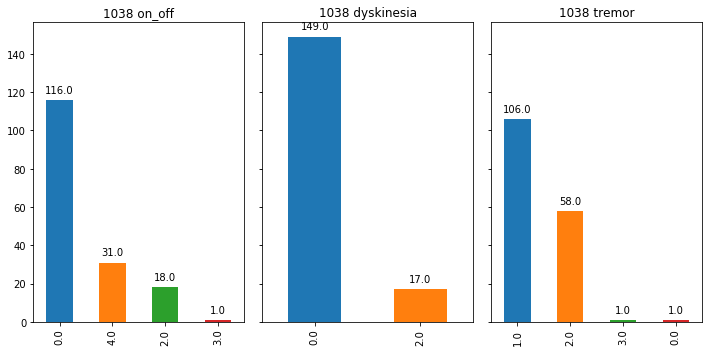

1038_test_kfold_3.csv
Nb subject_id :  1


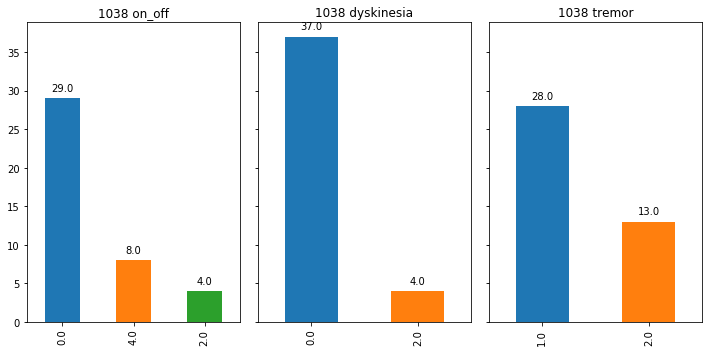

1038_train_kfold_4.csv
Nb subject_id :  1


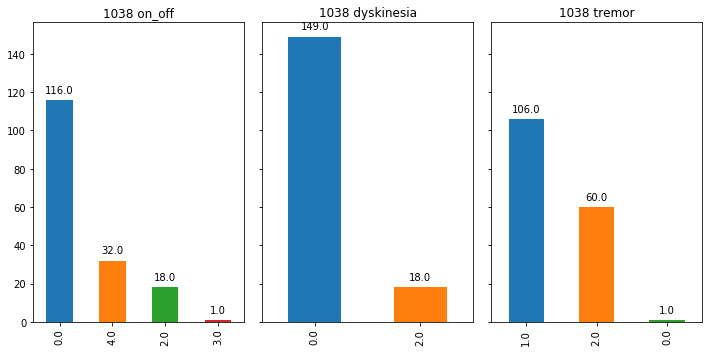

1038_test_kfold_4.csv
Nb subject_id :  1


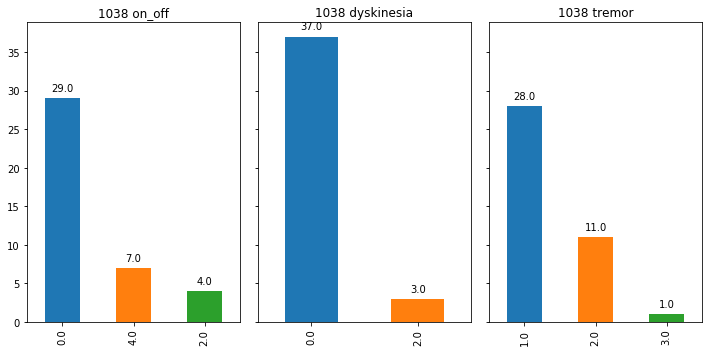

1039_train_kfold_0.csv
Nb subject_id :  1


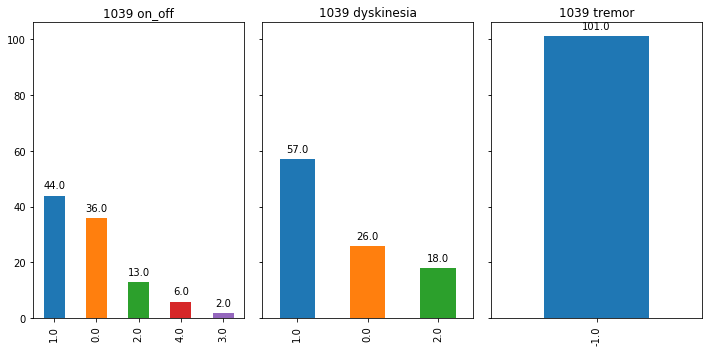

1039_test_kfold_0.csv
Nb subject_id :  1


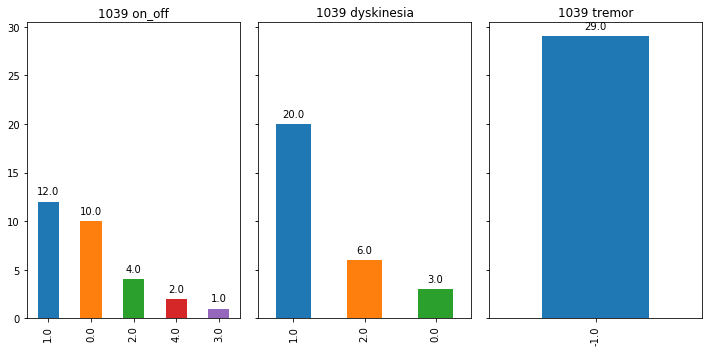

1039_train_kfold_1.csv
Nb subject_id :  1


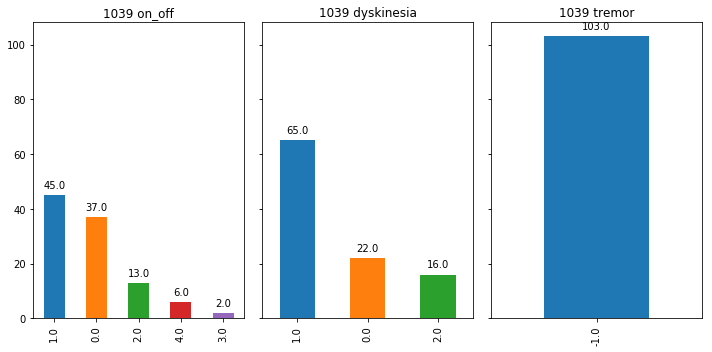

1039_test_kfold_1.csv
Nb subject_id :  1


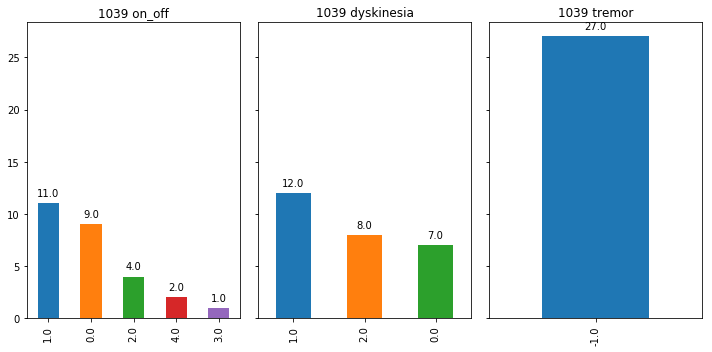

1039_train_kfold_2.csv
Nb subject_id :  1


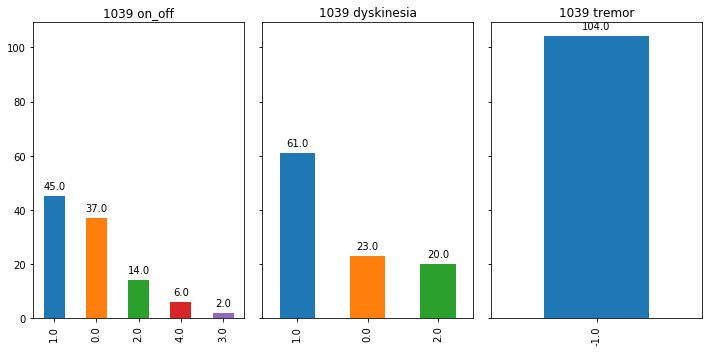

1039_test_kfold_2.csv
Nb subject_id :  1


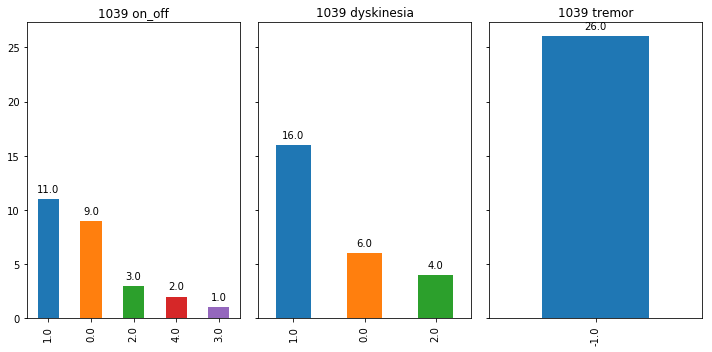

1039_train_kfold_3.csv
Nb subject_id :  1


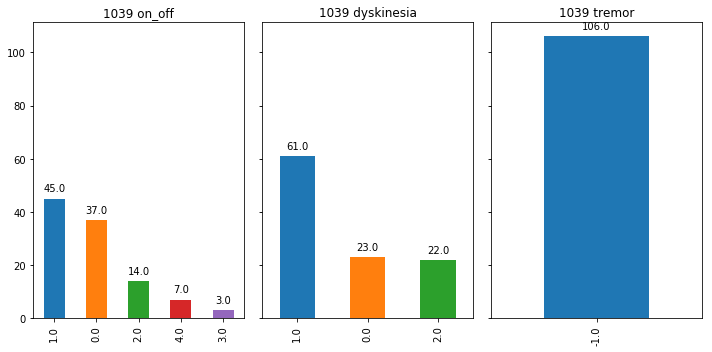

1039_test_kfold_3.csv
Nb subject_id :  1


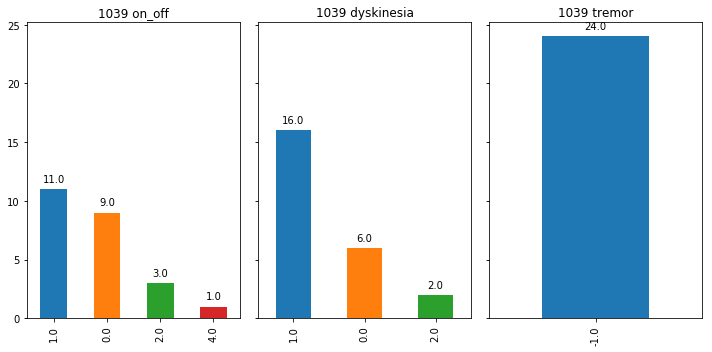

1039_train_kfold_4.csv
Nb subject_id :  1


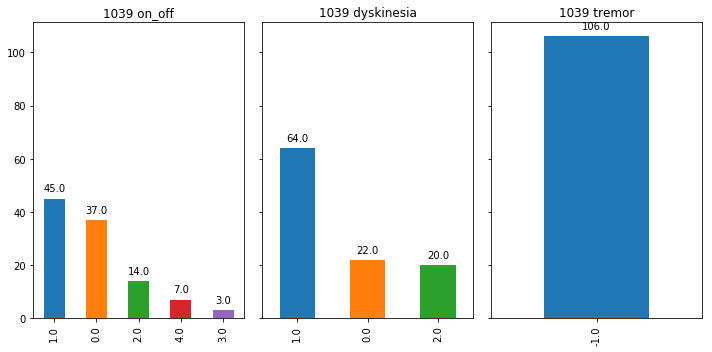

1039_test_kfold_4.csv
Nb subject_id :  1


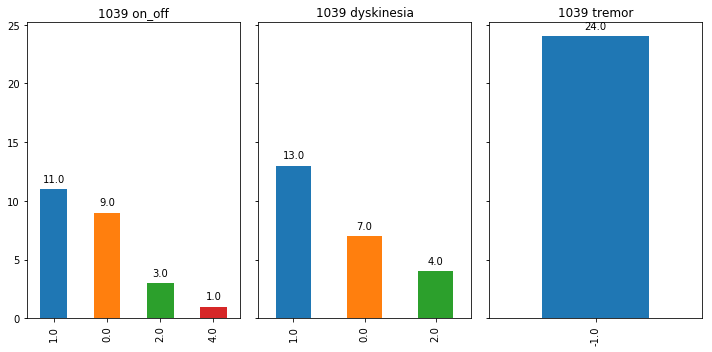

1043_train_kfold_0.csv
Nb subject_id :  1


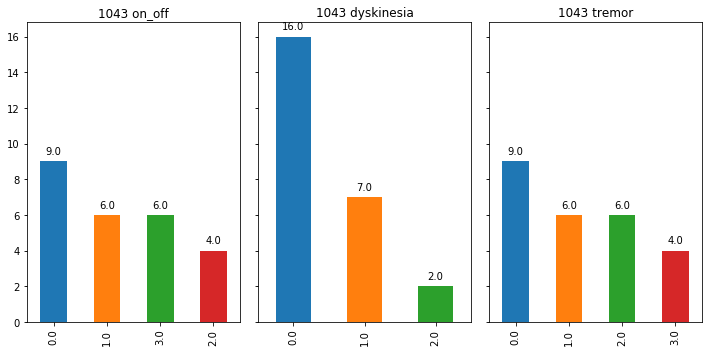

1043_test_kfold_0.csv
Nb subject_id :  1


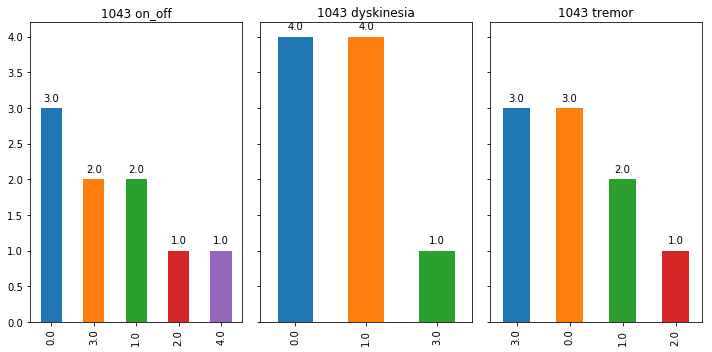

1043_train_kfold_1.csv
Nb subject_id :  1


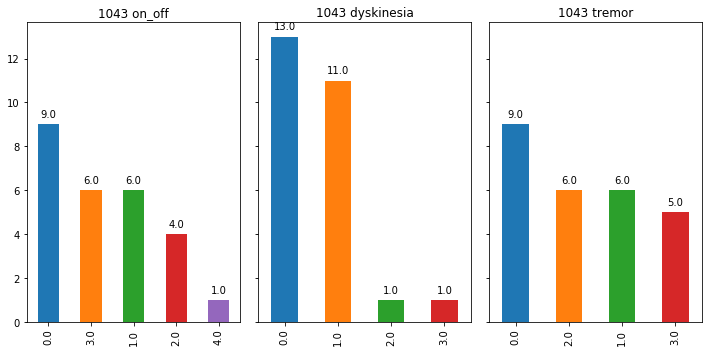

1043_test_kfold_1.csv
Nb subject_id :  1


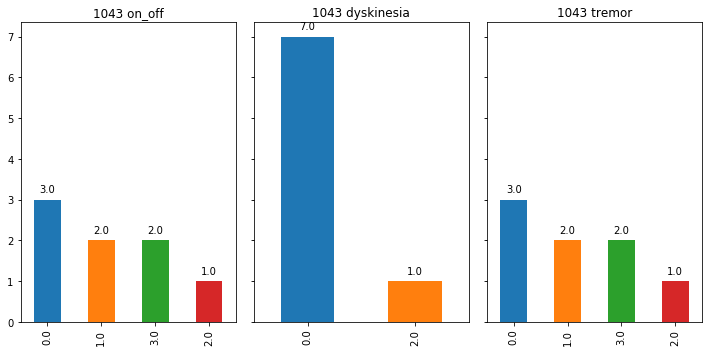

1043_train_kfold_2.csv
Nb subject_id :  1


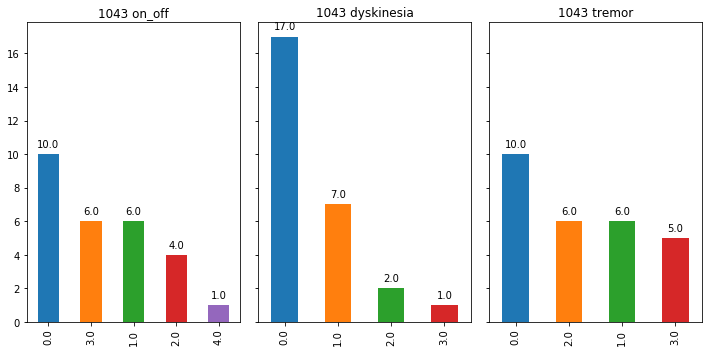

1043_test_kfold_2.csv
Nb subject_id :  1


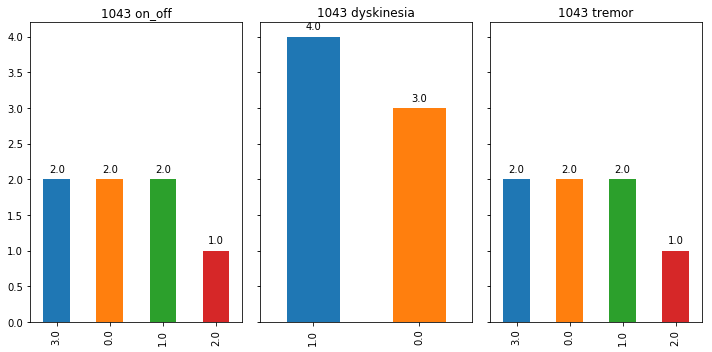

1043_train_kfold_3.csv
Nb subject_id :  1


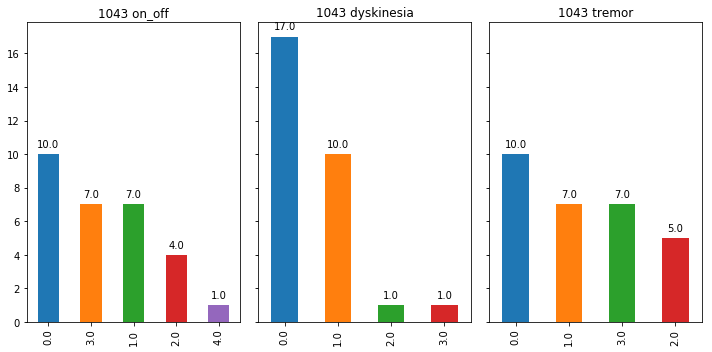

1043_test_kfold_3.csv
Nb subject_id :  1


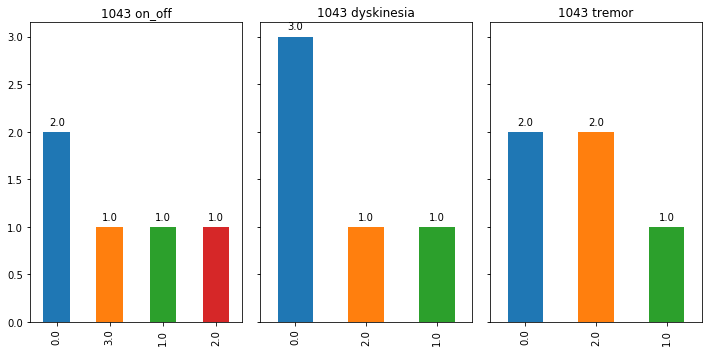

1043_train_kfold_4.csv
Nb subject_id :  1


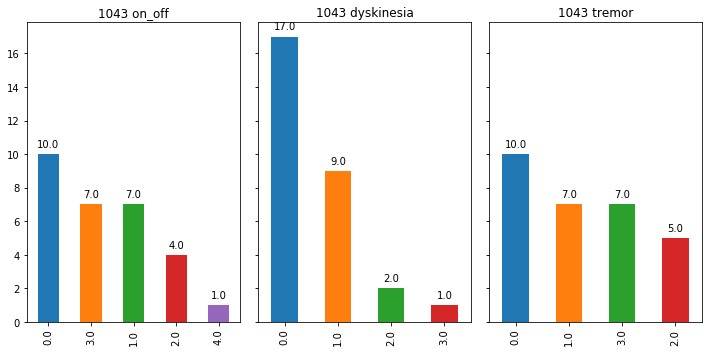

1043_test_kfold_4.csv
Nb subject_id :  1


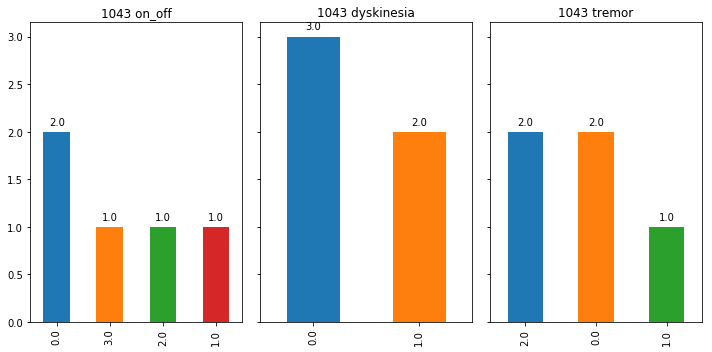

1044_train_kfold_0.csv
Nb subject_id :  1


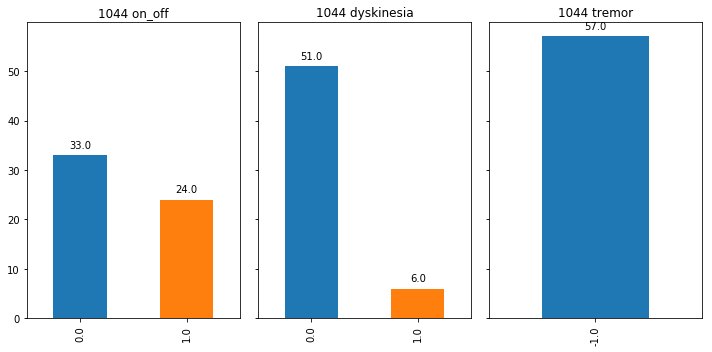

1044_test_kfold_0.csv
Nb subject_id :  1


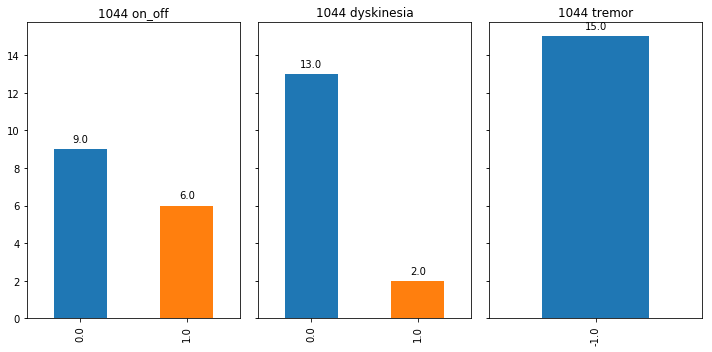

1044_train_kfold_1.csv
Nb subject_id :  1


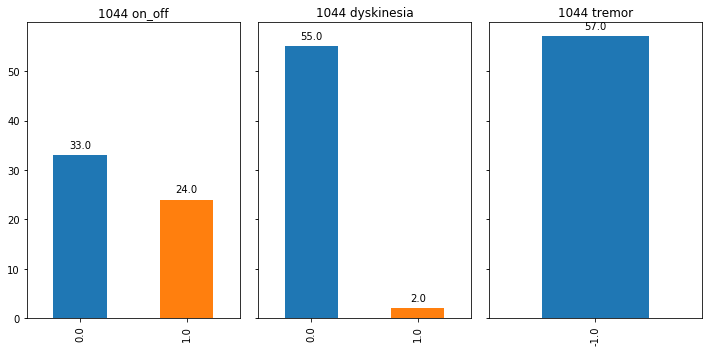

1044_test_kfold_1.csv
Nb subject_id :  1


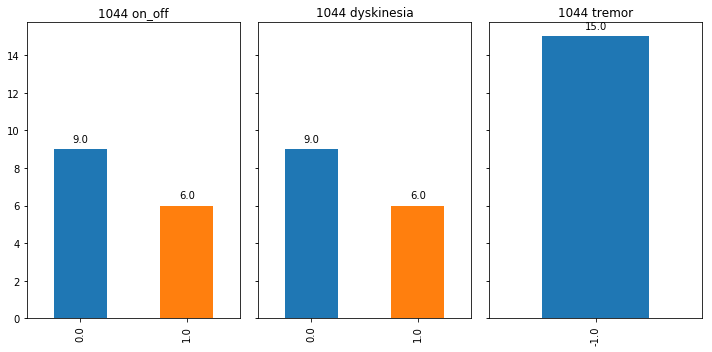

1044_train_kfold_2.csv
Nb subject_id :  1


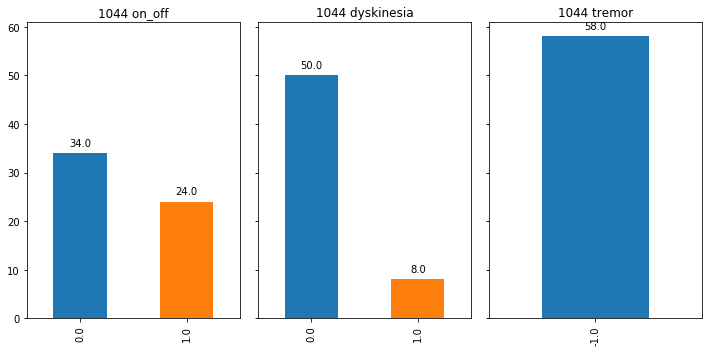

1044_test_kfold_2.csv
Nb subject_id :  1


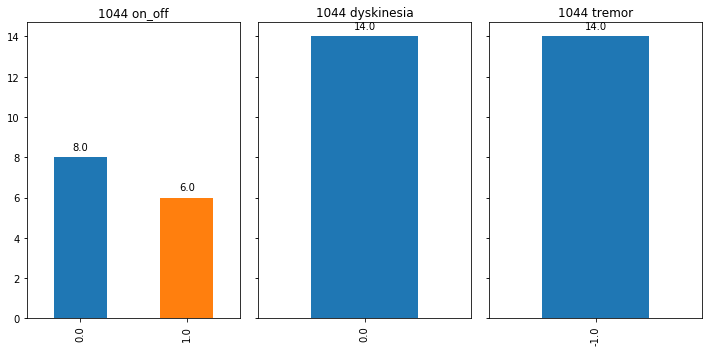

1044_train_kfold_3.csv
Nb subject_id :  1


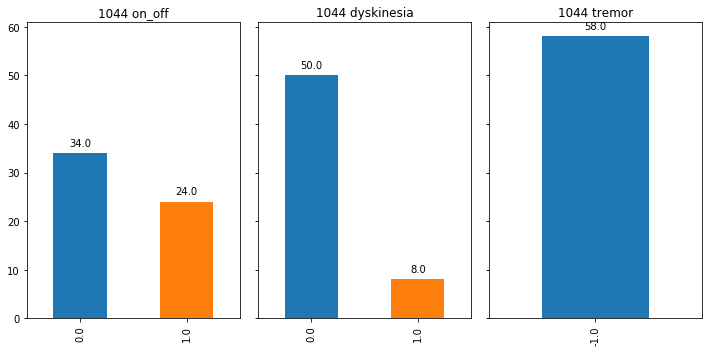

1044_test_kfold_3.csv
Nb subject_id :  1


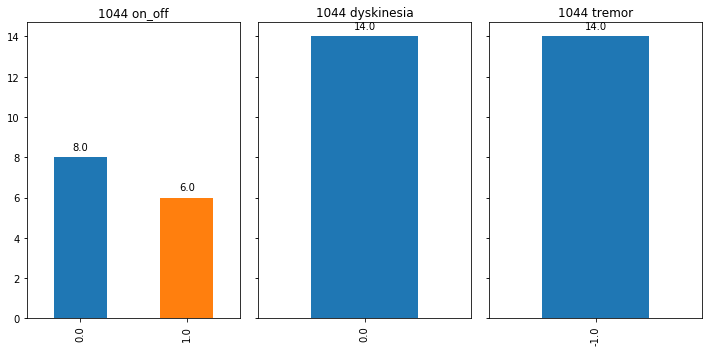

1044_train_kfold_4.csv
Nb subject_id :  1


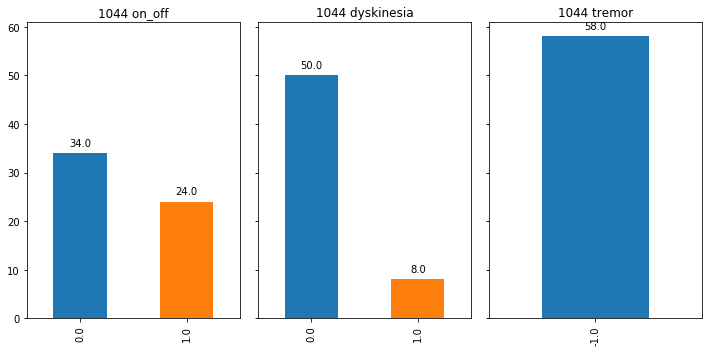

1044_test_kfold_4.csv
Nb subject_id :  1


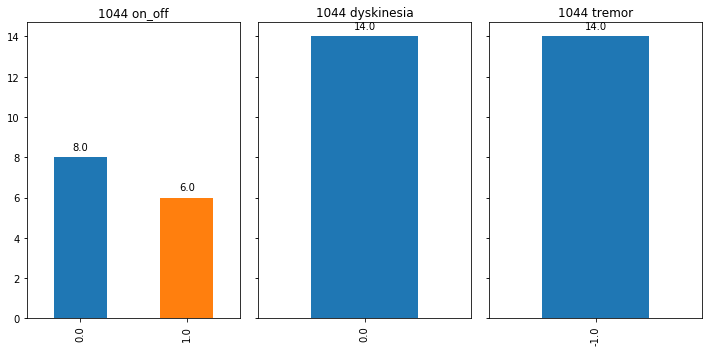

1046_train_kfold_0.csv
Nb subject_id :  1


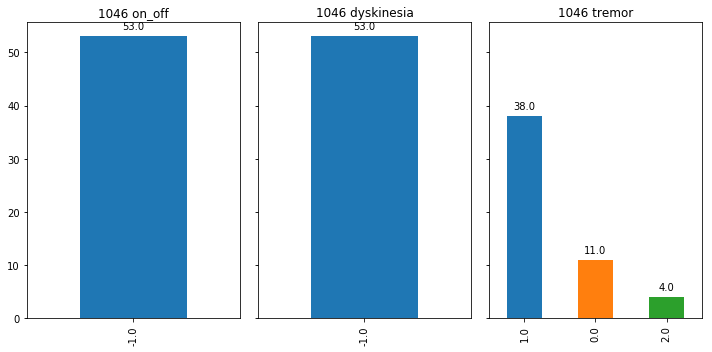

1046_test_kfold_0.csv
Nb subject_id :  1


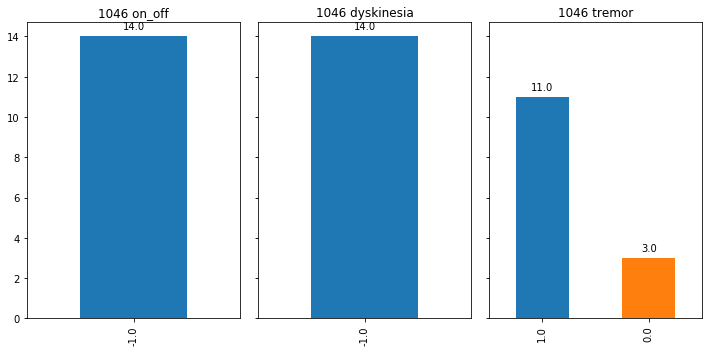

1046_train_kfold_1.csv
Nb subject_id :  1


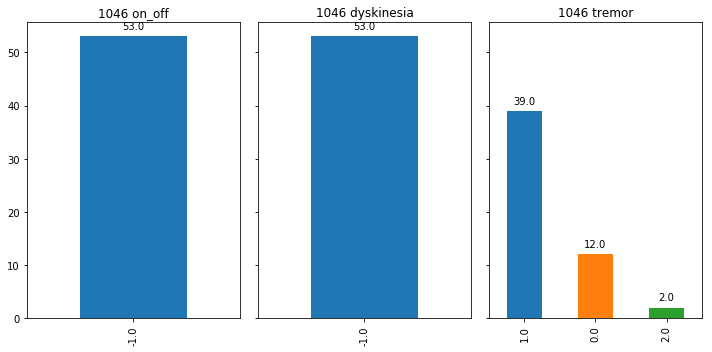

1046_test_kfold_1.csv
Nb subject_id :  1


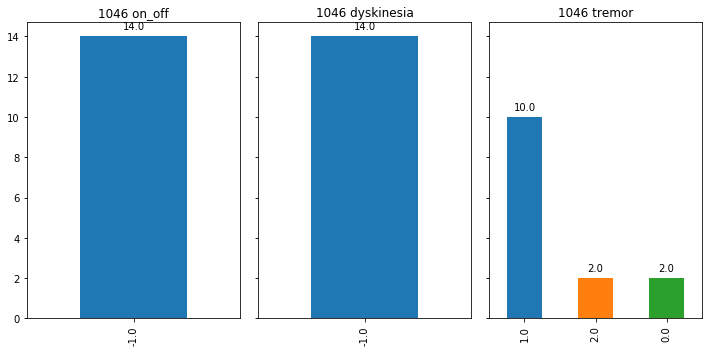

1046_train_kfold_2.csv
Nb subject_id :  1


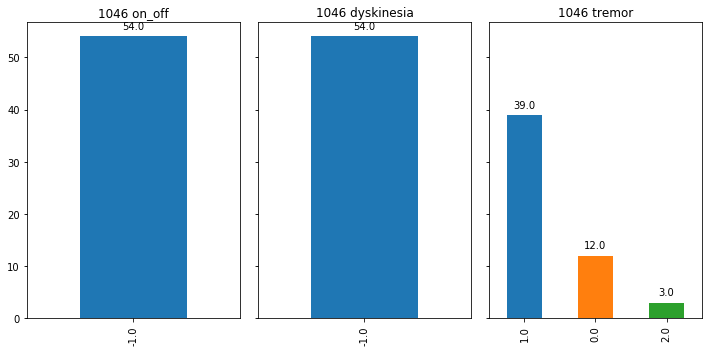

1046_test_kfold_2.csv
Nb subject_id :  1


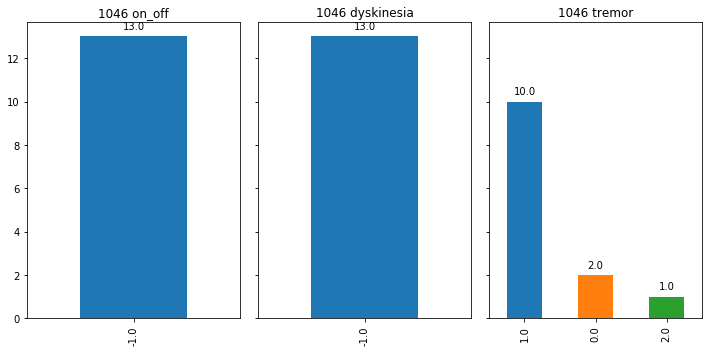

1046_train_kfold_3.csv
Nb subject_id :  1


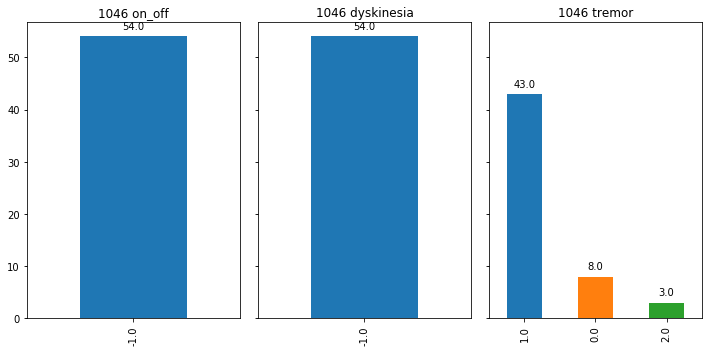

1046_test_kfold_3.csv
Nb subject_id :  1


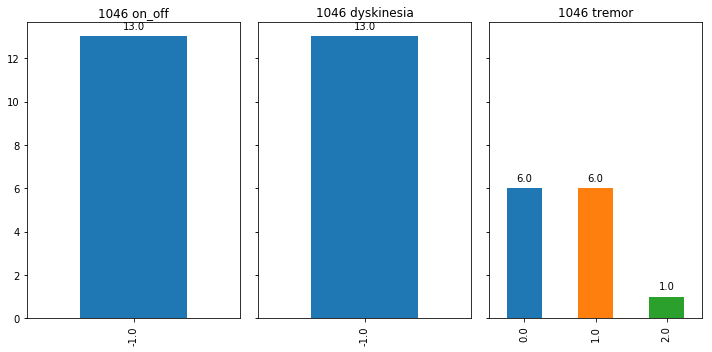

1046_train_kfold_4.csv
Nb subject_id :  1


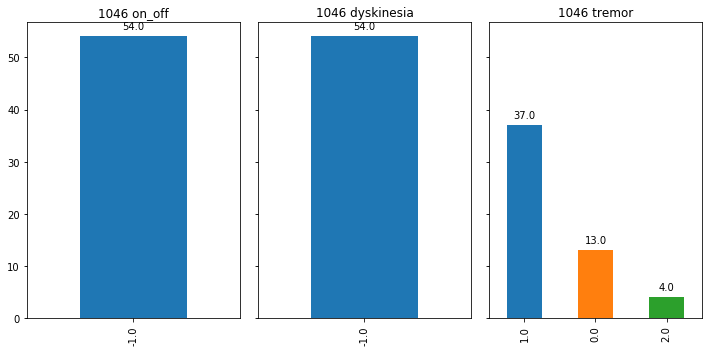

1046_test_kfold_4.csv
Nb subject_id :  1


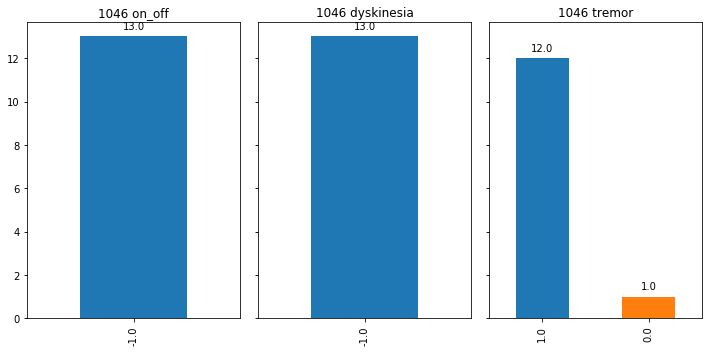

1048_train_kfold_0.csv
Nb subject_id :  1


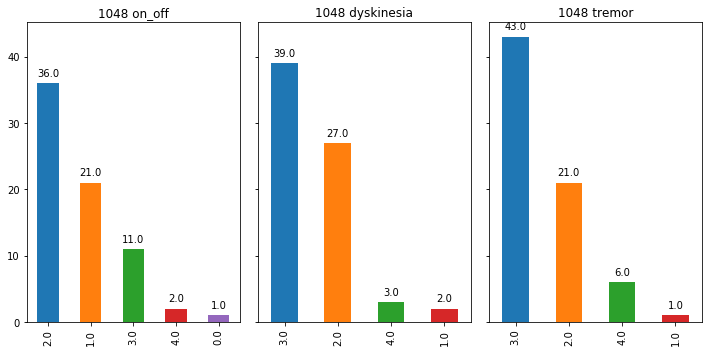

1048_test_kfold_0.csv
Nb subject_id :  1


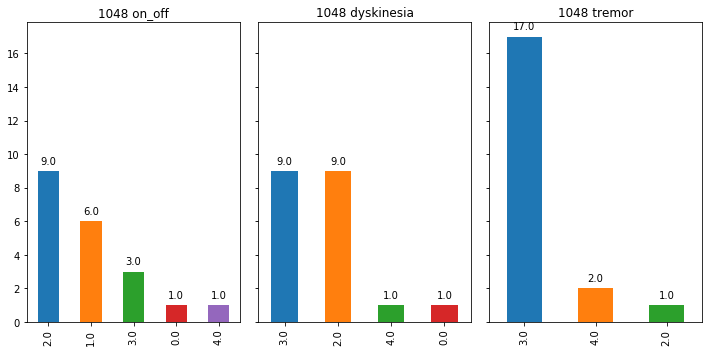

1048_train_kfold_1.csv
Nb subject_id :  1


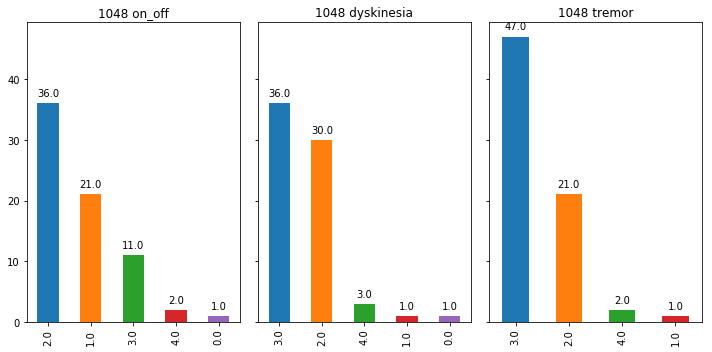

1048_test_kfold_1.csv
Nb subject_id :  1


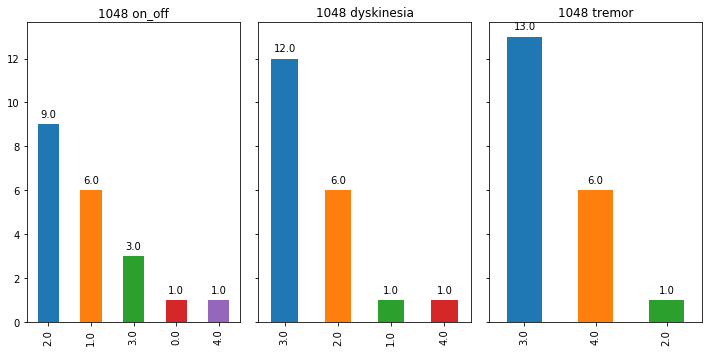

1048_train_kfold_2.csv
Nb subject_id :  1


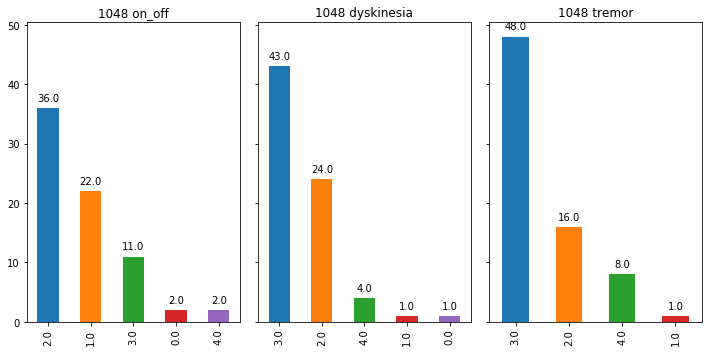

1048_test_kfold_2.csv
Nb subject_id :  1


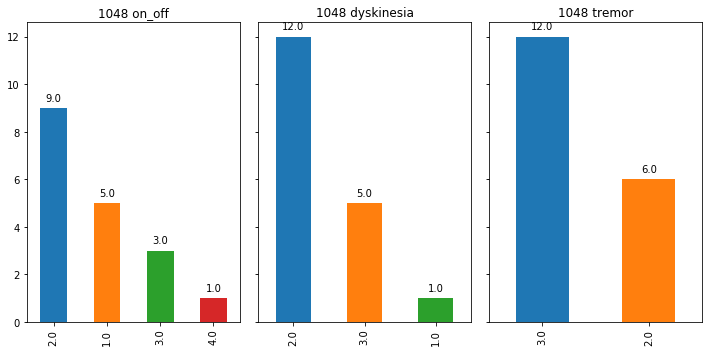

1048_train_kfold_3.csv
Nb subject_id :  1


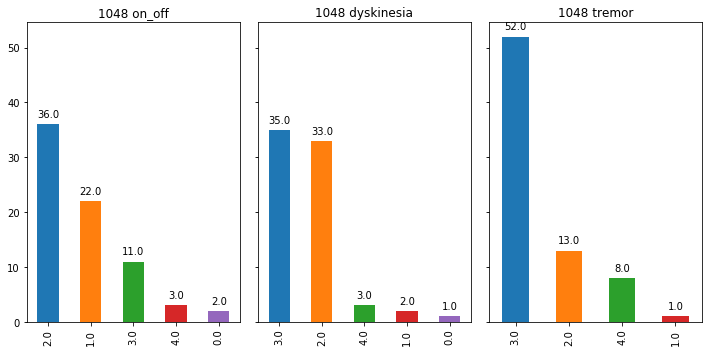

1048_test_kfold_3.csv
Nb subject_id :  1


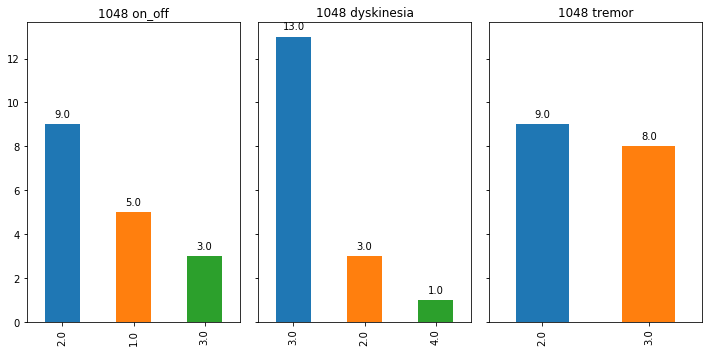

1048_train_kfold_4.csv
Nb subject_id :  1


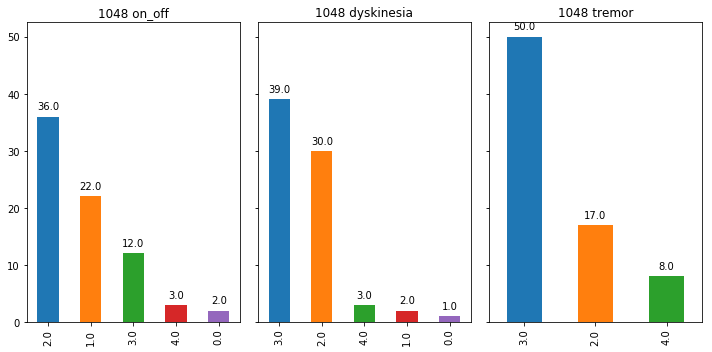

1048_test_kfold_4.csv
Nb subject_id :  1


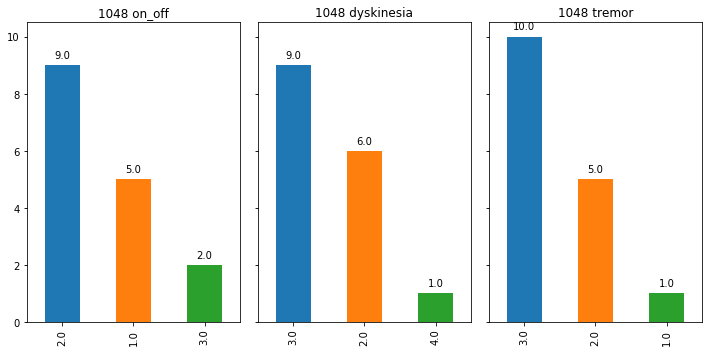

1049_train_kfold_0.csv
Nb subject_id :  1


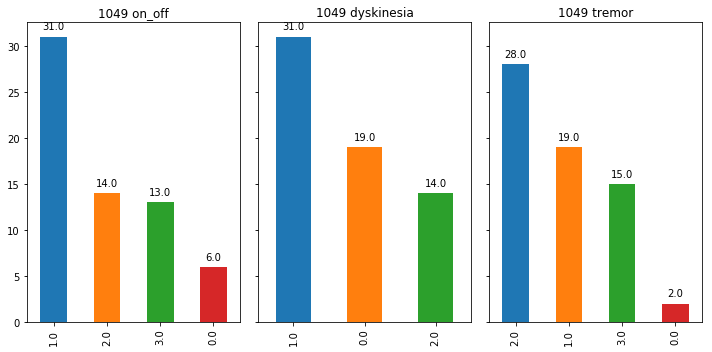

1049_test_kfold_0.csv
Nb subject_id :  1


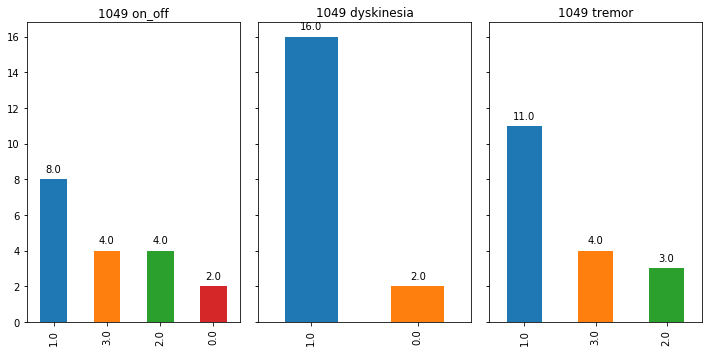

1049_train_kfold_1.csv
Nb subject_id :  1


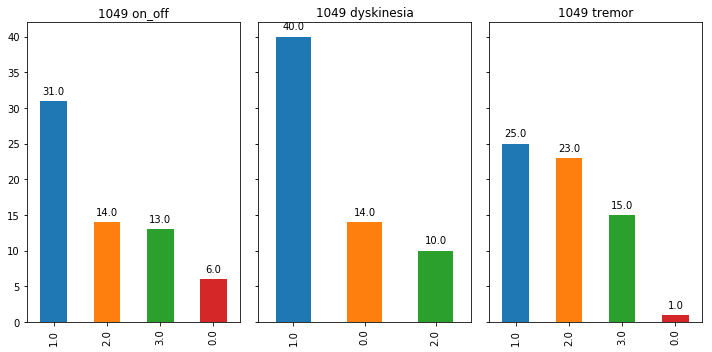

1049_test_kfold_1.csv
Nb subject_id :  1


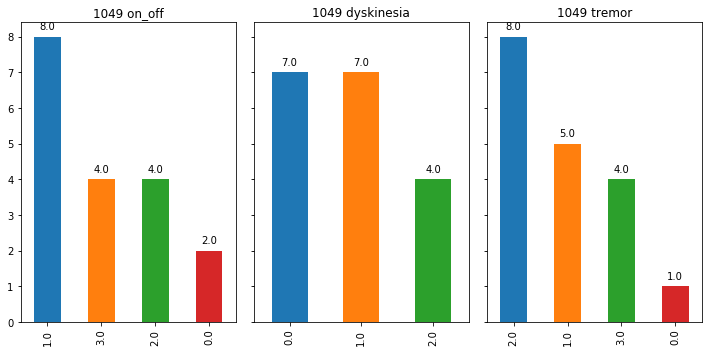

1049_train_kfold_2.csv
Nb subject_id :  1


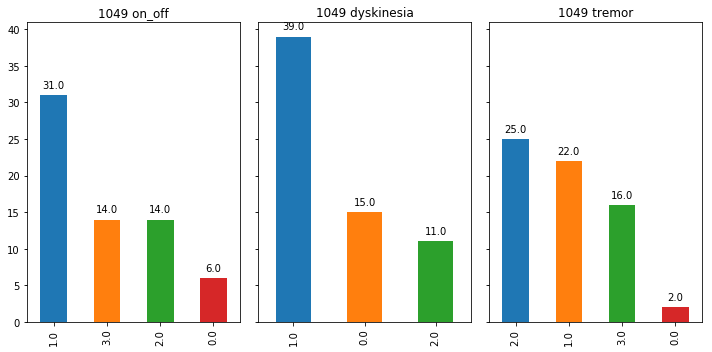

1049_test_kfold_2.csv
Nb subject_id :  1


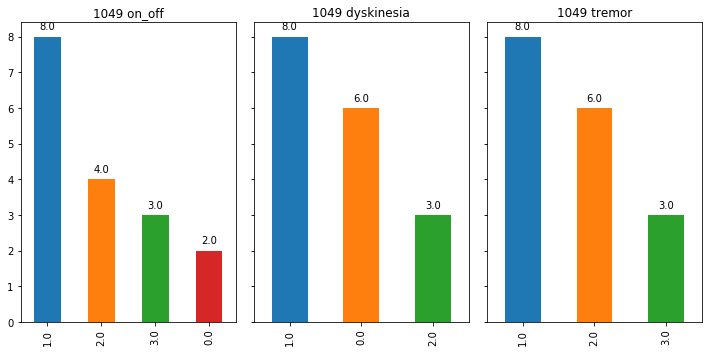

1049_train_kfold_3.csv
Nb subject_id :  1


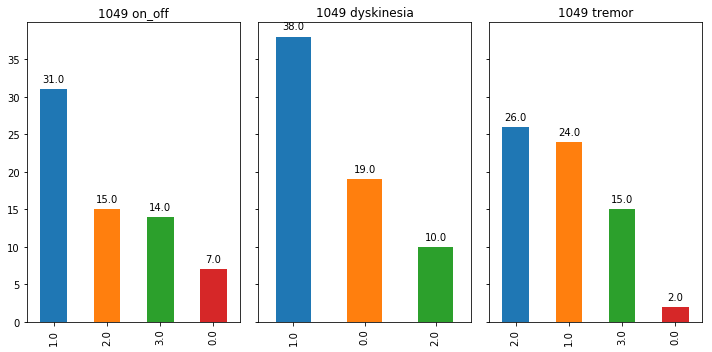

1049_test_kfold_3.csv
Nb subject_id :  1


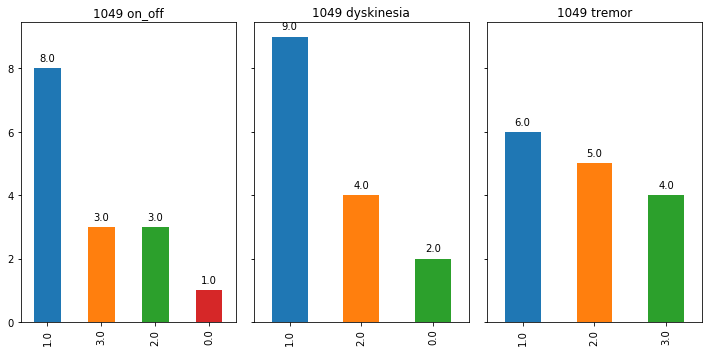

1049_train_kfold_4.csv
Nb subject_id :  1


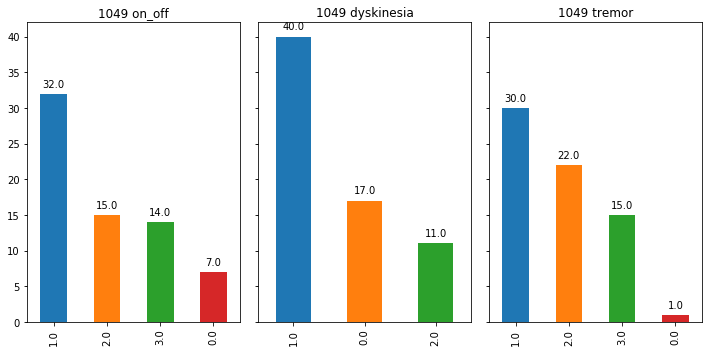

1049_test_kfold_4.csv
Nb subject_id :  1


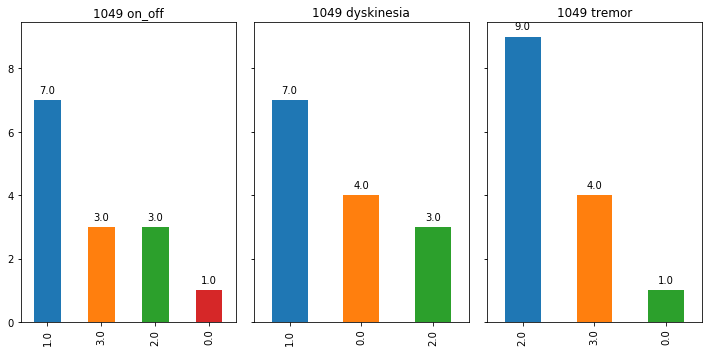

1051_train_kfold_0.csv
Nb subject_id :  1


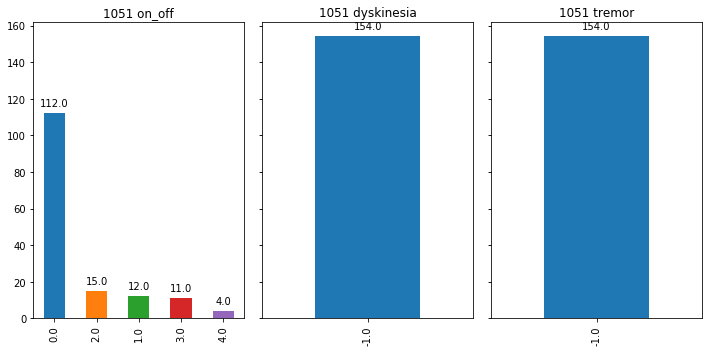

1051_test_kfold_0.csv
Nb subject_id :  1


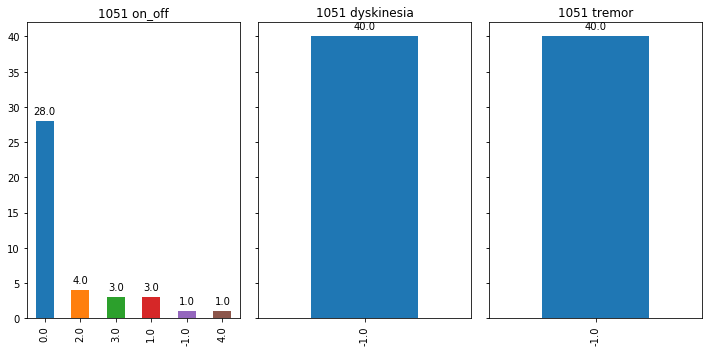

1051_train_kfold_1.csv
Nb subject_id :  1


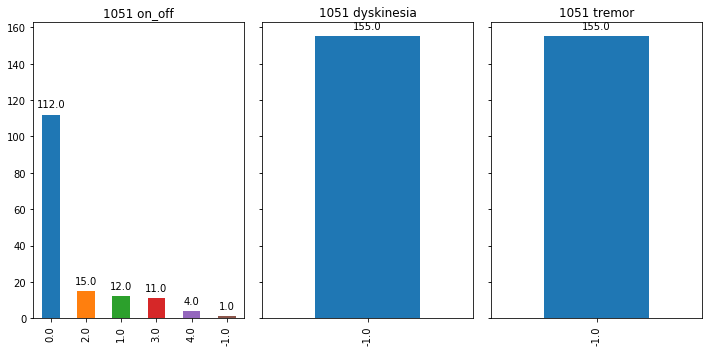

1051_test_kfold_1.csv
Nb subject_id :  1


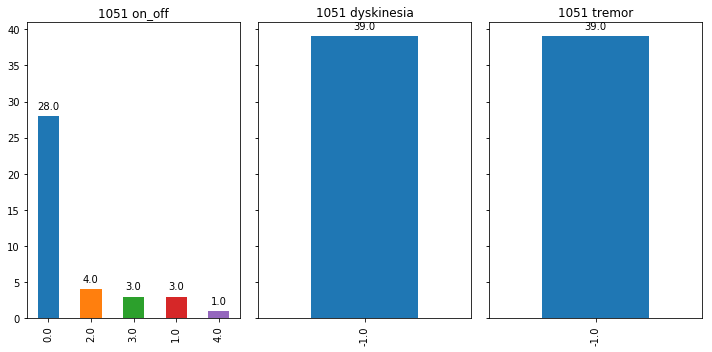

1051_train_kfold_2.csv
Nb subject_id :  1


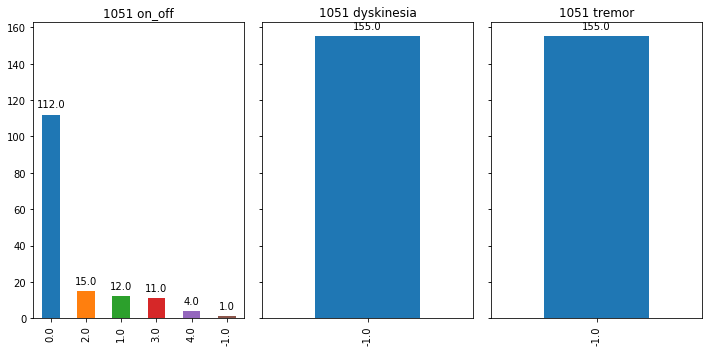

1051_test_kfold_2.csv
Nb subject_id :  1


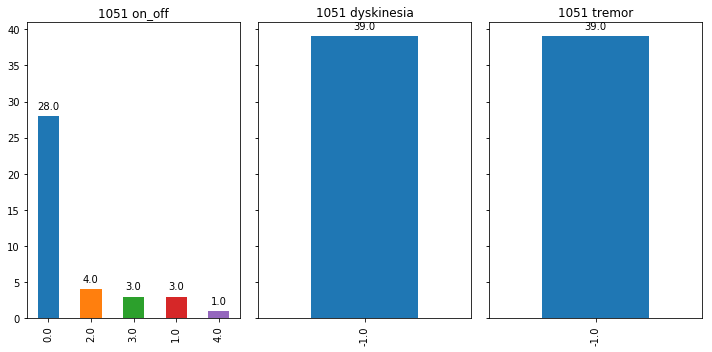

1051_train_kfold_3.csv
Nb subject_id :  1


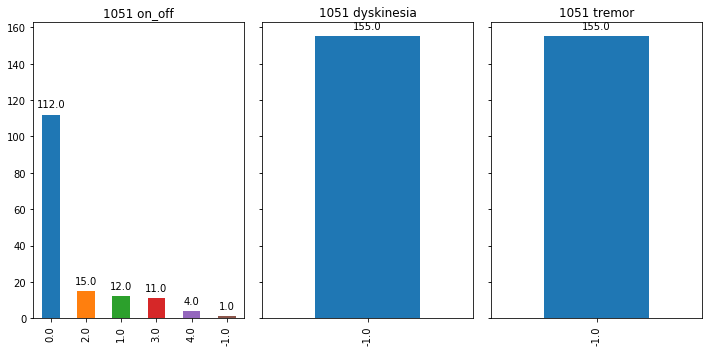

1051_test_kfold_3.csv
Nb subject_id :  1


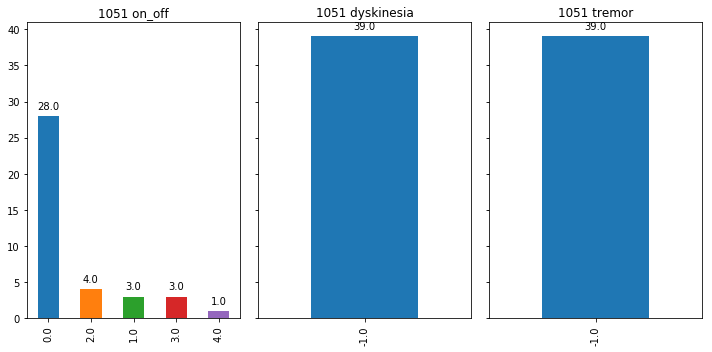

1051_train_kfold_4.csv
Nb subject_id :  1


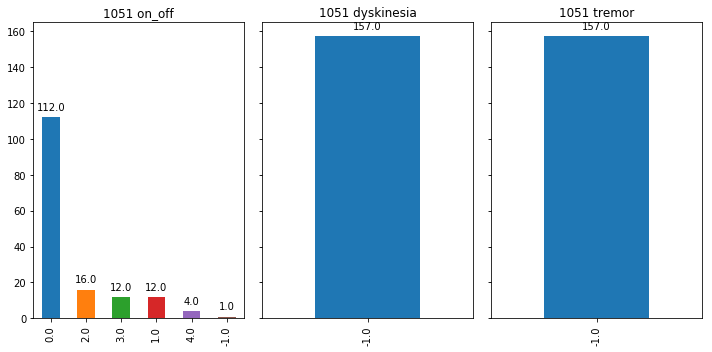

1051_test_kfold_4.csv
Nb subject_id :  1


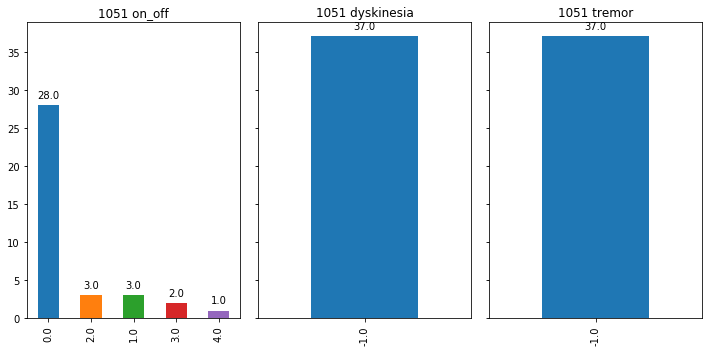

In [46]:
data_type = "cis"
data_real_subtype=""

if data_type == "cis":
    kfold_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.k_fold_v2/"

data_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/"
data_path = data_path + data_type + "-pd.training_data/" + data_real_subtype + "/"

nb_folds = np.array([0,1,2,3,4])

pids = np.array([1004,1006,1007,1019,1020,1023,1032,1034,1038,1039,1043,1044,1046,1048,1049,1051])

for temp_pid in pids:
    for nb in nb_folds:
        for train_or_test in ['train','test']:
            file_name = str(temp_pid) + '_'+train_or_test+'_kfold_' + str(nb) + '.csv'
            print(file_name)
            df_train_label = pd.read_csv(kfold_path+file_name)
            # Compute the occurences of each symptoms for each patient

            df_occurences, df_train_label_subject_id = compute_symptoms_occurences_dataframe(
                df_train_label=df_train_label
            )

            # Plot the graphs
            plot_symptoms_occurences(
                df_occurences=df_occurences, df_train_label_subject_id=df_train_label_subject_id
            )

            #print(df_train_label.values[:,1:])
            #temp_train_X = pd.read_csv(data_path+df_train_label["measurement_id"][idx] + '.csv')